In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q opencv-python

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
# from "movenet" import Movenet
!pip install wget --quiet
import wget
import csv
import sys
import tqdm 

  Preparing metadata (setup.py) ... done


In [ ]:
# BLOG LINK
"https://medium.com/@leahnagy/yoga-pose-classification-with-tensorflows-movenet-model-3e5771fda292"

'https://medium.com/@leahnagy/yoga-pose-classification-with-tensorflows-movenet-model-3e5771fda292'

In [ ]:
# Download model from TF Hub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

Cloning into 'examples'...
remote: Enumerating objects: 23379, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 23379 (delta 93), reused 311 (delta 79), pack-reused 23039
Receiving objects: 100% (23379/23379), 43.90 MiB | 29.46 MiB/s, done.
Resolving deltas: 100% (12750/12750), done.


In [ ]:
# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [ ]:
# this module is taken from tensorflow example repository to use functions and algorithms in the project

# Copyright 2021 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Module contains the data types used in pose estimation."""

import enum
from typing import List, NamedTuple

import numpy as np


class BodyPart(enum.Enum):
  """Enum representing human body keypoints detected by pose estimation models."""
  NOSE = 0
  LEFT_EYE = 1
  RIGHT_EYE = 2
  LEFT_EAR = 3
  RIGHT_EAR = 4
  LEFT_SHOULDER = 5
  RIGHT_SHOULDER = 6
  LEFT_ELBOW = 7
  RIGHT_ELBOW = 8
  LEFT_WRIST = 9
  RIGHT_WRIST = 10
  LEFT_HIP = 11
  RIGHT_HIP = 12
  LEFT_KNEE = 13
  RIGHT_KNEE = 14
  LEFT_ANKLE = 15
  RIGHT_ANKLE = 16


class Point(NamedTuple):
  """A point in 2D space."""
  x: float
  y: float


class Rectangle(NamedTuple):
  """A rectangle in 2D space."""
  start_point: Point
  end_point: Point


class KeyPoint(NamedTuple):
  """A detected human keypoint."""
  body_part: BodyPart
  coordinate: Point
  score: float


class Person(NamedTuple):
  """A pose detected by a pose estimation model."""
  keypoints: List[KeyPoint]
  bounding_box: Rectangle
  score: float
  id: int = None


def person_from_keypoints_with_scores(
    keypoints_with_scores: np.ndarray,
    image_height: float,
    image_width: float,
    keypoint_score_threshold: float = 0.1) -> Person:
  """Creates a Person instance from single pose estimation model output.

  Args:
    keypoints_with_scores: Output of the TFLite pose estimation model. A numpy
      array with shape [17, 3]. Each row represents a keypoint: [y, x, score].
    image_height: height of the image in pixels.
    image_width: width of the image in pixels.
    keypoint_score_threshold: Only use keypoints with above this threshold to
      calculate the person average score.

  Returns:
    A Person instance.
  """

  kpts_x = keypoints_with_scores[:, 1]
  kpts_y = keypoints_with_scores[:, 0]
  scores = keypoints_with_scores[:, 2]

  # Convert keypoints to the input image coordinate system.
  keypoints = []
  for i in range(scores.shape[0]):
    keypoints.append(
        KeyPoint(
            BodyPart(i),
            Point(int(kpts_x[i] * image_width), int(kpts_y[i] * image_height)),
            scores[i]))

  # Calculate bounding box as SinglePose models don't return bounding box.
  start_point = Point(
      int(np.amin(kpts_x) * image_width), int(np.amin(kpts_y) * image_height))
  end_point = Point(
      int(np.amax(kpts_x) * image_width), int(np.amax(kpts_y) * image_height))
  bounding_box = Rectangle(start_point, end_point)

  # Calculate person score by averaging keypoint scores.
  scores_above_threshold = list(
      filter(lambda x: x > keypoint_score_threshold, scores))
  person_score = np.average(scores_above_threshold)

  return Person(keypoints, bounding_box, person_score)


class Category(NamedTuple):
  """A classification category."""
  label: str
  score: float


In [ ]:
# this module is taken from tensorflow example repository to use functions and algorithms in the project
"""Code to run a pose estimation with a TFLite MoveNet model."""

import os
from typing import Dict, List

import cv2
# from data import BodyPart
# from data import Person
# from data import person_from_keypoints_with_scores
import numpy as np

# pylint: disable=g-import-not-at-top
try:
  # Import TFLite interpreter from tflite_runtime package if it's available.
  from tflite_runtime.interpreter import Interpreter
except ImportError:
  # If not, fallback to use the TFLite interpreter from the full TF package.
  import tensorflow as tf
  Interpreter = tf.lite.Interpreter
# pylint: enable=g-import-not-at-top


class Movenet(object):
  """A wrapper class for a Movenet TFLite pose estimation model."""

  # Configure how confidence the model should be on the detected keypoints to
  # proceed with using smart cropping logic.
  _MIN_CROP_KEYPOINT_SCORE = 0.2
  _TORSO_EXPANSION_RATIO = 1.9
  _BODY_EXPANSION_RATIO = 1.2

  def __init__(self, model_name: str) -> None:
    """Initialize a MoveNet pose estimation model.

    Args:
      model_name: Name of the TFLite MoveNet model.
    """

    # Append TFLITE extension to model_name if there's no extension
    _, ext = os.path.splitext(model_name)
    if not ext:
      model_name += '.tflite'

    # Initialize model
    interpreter = Interpreter(model_path=model_name, num_threads=4)
    interpreter.allocate_tensors()

    self._input_index = interpreter.get_input_details()[0]['index']
    self._output_index = interpreter.get_output_details()[0]['index']

    self._input_height = interpreter.get_input_details()[0]['shape'][1]
    self._input_width = interpreter.get_input_details()[0]['shape'][2]

    self._interpreter = interpreter
    self._crop_region = None

  def init_crop_region(self, image_height: int,
                       image_width: int) -> Dict[(str, float)]:
    """Defines the default crop region.

    The function provides the initial crop region (pads the full image from
    both sides to make it a square image) when the algorithm cannot reliably
    determine the crop region from the previous frame.

    Args:
      image_height (int): The input image width
      image_width (int): The input image height

    Returns:
      crop_region (dict): The default crop region.
    """
    if image_width > image_height:
      x_min = 0.0
      box_width = 1.0
      # Pad the vertical dimension to become a square image.
      y_min = (image_height / 2 - image_width / 2) / image_height
      box_height = image_width / image_height
    else:
      y_min = 0.0
      box_height = 1.0
      # Pad the horizontal dimension to become a square image.
      x_min = (image_width / 2 - image_height / 2) / image_width
      box_width = image_height / image_width

    return {
        'y_min': y_min,
        'x_min': x_min,
        'y_max': y_min + box_height,
        'x_max': x_min + box_width,
        'height': box_height,
        'width': box_width
    }

  def _torso_visible(self, keypoints: np.ndarray) -> bool:
    """Checks whether there are enough torso keypoints.

    This function checks whether the model is confident at predicting one of
    the shoulders/hips which is required to determine a good crop region.

    Args:
      keypoints: Detection result of Movenet model.

    Returns:
      True/False
    """
    left_hip_score = keypoints[BodyPart.LEFT_HIP.value, 2]
    right_hip_score = keypoints[BodyPart.RIGHT_HIP.value, 2]
    left_shoulder_score = keypoints[BodyPart.LEFT_SHOULDER.value, 2]
    right_shoulder_score = keypoints[BodyPart.RIGHT_SHOULDER.value, 2]

    left_hip_visible = left_hip_score > Movenet._MIN_CROP_KEYPOINT_SCORE
    right_hip_visible = right_hip_score > Movenet._MIN_CROP_KEYPOINT_SCORE
    left_shoulder_visible = left_shoulder_score > Movenet._MIN_CROP_KEYPOINT_SCORE
    right_shoulder_visible = right_shoulder_score > Movenet._MIN_CROP_KEYPOINT_SCORE

    return ((left_hip_visible or right_hip_visible) and
            (left_shoulder_visible or right_shoulder_visible))

  def _determine_torso_and_body_range(self, keypoints: np.ndarray,
                                      target_keypoints: Dict[(str, float)],
                                      center_y: float,
                                      center_x: float) -> List[float]:
    """Calculates the maximum distance from each keypoints to the center.

    The function returns the maximum distances from the two sets of keypoints:
    full 17 keypoints and 4 torso keypoints. The returned information will
    be used to determine the crop size. See determine_crop_region for more
    details.

    Args:
      keypoints: Detection result of Movenet model.
      target_keypoints: The 4 torso keypoints.
      center_y (float): Vertical coordinate of the body center.
      center_x (float): Horizontal coordinate of the body center.

    Returns:
      The maximum distance from each keypoints to the center location.
    """
    torso_joints = [
        BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER, BodyPart.LEFT_HIP,
        BodyPart.RIGHT_HIP
    ]
    max_torso_yrange = 0.0
    max_torso_xrange = 0.0
    for joint in torso_joints:
      dist_y = abs(center_y - target_keypoints[joint][0])
      dist_x = abs(center_x - target_keypoints[joint][1])
      if dist_y > max_torso_yrange:
        max_torso_yrange = dist_y
      if dist_x > max_torso_xrange:
        max_torso_xrange = dist_x

    max_body_yrange = 0.0
    max_body_xrange = 0.0
    for idx in range(len(BodyPart)):
      if keypoints[BodyPart(idx).value, 2] < Movenet._MIN_CROP_KEYPOINT_SCORE:
        continue
      dist_y = abs(center_y - target_keypoints[joint][0])
      dist_x = abs(center_x - target_keypoints[joint][1])
      if dist_y > max_body_yrange:
        max_body_yrange = dist_y

      if dist_x > max_body_xrange:
        max_body_xrange = dist_x

    return [
        max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange
    ]

  def _determine_crop_region(self, keypoints: np.ndarray, image_height: int,
                             image_width: int) -> Dict[(str, float)]:
    """Determines the region to crop the image for the model to run inference on.

    The algorithm uses the detected joints from the previous frame to
    estimate the square region that encloses the full body of the target
    person and centers at the midpoint of two hip joints. The crop size is
    determined by the distances between each joints and the center point.
    When the model is not confident with the four torso joint predictions,
    the function returns a default crop which is the full image padded to
    square.

    Args:
      keypoints: Detection result of Movenet model.
      image_height (int): The input image width
      image_width (int): The input image height

    Returns:
      crop_region (dict): The crop region to run inference on.
    """
    # Convert keypoint index to human-readable names.
    target_keypoints = {}
    for idx in range(len(BodyPart)):
      target_keypoints[BodyPart(idx)] = [
          keypoints[idx, 0] * image_height, keypoints[idx, 1] * image_width
      ]

    # Calculate crop region if the torso is visible.
    if self._torso_visible(keypoints):
      center_y = (target_keypoints[BodyPart.LEFT_HIP][0] +
                  target_keypoints[BodyPart.RIGHT_HIP][0]) / 2
      center_x = (target_keypoints[BodyPart.LEFT_HIP][1] +
                  target_keypoints[BodyPart.RIGHT_HIP][1]) / 2

      (max_torso_yrange, max_torso_xrange, max_body_yrange,
       max_body_xrange) = self._determine_torso_and_body_range(
           keypoints, target_keypoints, center_y, center_x)

      crop_length_half = np.amax([
          max_torso_xrange * Movenet._TORSO_EXPANSION_RATIO,
          max_torso_yrange * Movenet._TORSO_EXPANSION_RATIO,
          max_body_yrange * Movenet._BODY_EXPANSION_RATIO,
          max_body_xrange * Movenet._BODY_EXPANSION_RATIO
      ])

      # Adjust crop length so that it is still within the image border
      distances_to_border = np.array(
          [center_x, image_width - center_x, center_y, image_height - center_y])
      crop_length_half = np.amin(
          [crop_length_half, np.amax(distances_to_border)])

      # If the body is large enough, there's no need to apply cropping logic.
      if crop_length_half > max(image_width, image_height) / 2:
        return self.init_crop_region(image_height, image_width)
      # Calculate the crop region that nicely covers the full body.
      else:
        crop_length = crop_length_half * 2
      crop_corner = [center_y - crop_length_half, center_x - crop_length_half]
      return {
          'y_min':
              crop_corner[0] / image_height,
          'x_min':
              crop_corner[1] / image_width,
          'y_max': (crop_corner[0] + crop_length) / image_height,
          'x_max': (crop_corner[1] + crop_length) / image_width,
          'height': (crop_corner[0] + crop_length) / image_height -
                    crop_corner[0] / image_height,
          'width': (crop_corner[1] + crop_length) / image_width -
                   crop_corner[1] / image_width
      }
    # Return the initial crop regsion if the torso isn't visible.
    else:
      return self.init_crop_region(image_height, image_width)

  def _crop_and_resize(
      self, image: np.ndarray, crop_region: Dict[(str, float)],
      crop_size: (int, int)) -> np.ndarray:
    """Crops and resize the image to prepare for the model input."""
    y_min, x_min, y_max, x_max = [
        crop_region['y_min'], crop_region['x_min'], crop_region['y_max'],
        crop_region['x_max']
    ]

    crop_top = int(0 if y_min < 0 else y_min * image.shape[0])
    crop_bottom = int(image.shape[0] if y_max >= 1 else y_max * image.shape[0])
    crop_left = int(0 if x_min < 0 else x_min * image.shape[1])
    crop_right = int(image.shape[1] if x_max >= 1 else x_max * image.shape[1])

    padding_top = int(0 - y_min * image.shape[0] if y_min < 0 else 0)
    padding_bottom = int((y_max - 1) * image.shape[0] if y_max >= 1 else 0)
    padding_left = int(0 - x_min * image.shape[1] if x_min < 0 else 0)
    padding_right = int((x_max - 1) * image.shape[1] if x_max >= 1 else 0)

    # Crop and resize image
    output_image = image[crop_top:crop_bottom, crop_left:crop_right]
    output_image = cv2.copyMakeBorder(output_image, padding_top, padding_bottom,
                                      padding_left, padding_right,
                                      cv2.BORDER_CONSTANT)
    output_image = cv2.resize(output_image, (crop_size[0], crop_size[1]))

    return output_image

  def _run_detector(
      self, image: np.ndarray, crop_region: Dict[(str, float)],
      crop_size: (int, int)) -> np.ndarray:
    """Runs model inference on the cropped region.

    The function runs the model inference on the cropped region and updates
    the model output to the original image coordinate system.

    Args:
      image: The input image.
      crop_region: The region of interest to run inference on.
      crop_size: The size of the crop region.

    Returns:
      An array of shape [17, 3] representing the keypoint absolute coordinates
      and scores.
    """

    input_image = self._crop_and_resize(image, crop_region, crop_size=crop_size)
    input_image = input_image.astype(dtype=np.uint8)

    self._interpreter.set_tensor(self._input_index,
                                 np.expand_dims(input_image, axis=0))
    self._interpreter.invoke()

    keypoints_with_scores = self._interpreter.get_tensor(self._output_index)
    keypoints_with_scores = np.squeeze(keypoints_with_scores)

    # Update the coordinates.
    for idx in range(len(BodyPart)):
      keypoints_with_scores[idx, 0] = crop_region[
          'y_min'] + crop_region['height'] * keypoints_with_scores[idx, 0]
      keypoints_with_scores[idx, 1] = crop_region[
          'x_min'] + crop_region['width'] * keypoints_with_scores[idx, 1]

    return keypoints_with_scores

  def detect(self,
             input_image: np.ndarray,
             reset_crop_region: bool = False) -> Person:
    """Run detection on an input image.

    Args:
      input_image: A [height, width, 3] RGB image. Note that height and width
        can be anything since the image will be immediately resized according to
        the needs of the model within this function.
      reset_crop_region: Whether to use the crop region inferred from the
        previous detection result to improve accuracy. Set to True if this is a
        frame from a video. Set to False if this is a static image. Default
        value is True.

    Returns:
      An array of shape [17, 3] representing the keypoint coordinates and
      scores.
    """
    image_height, image_width, _ = input_image.shape
    if (self._crop_region is None) or reset_crop_region:
      # Set crop region for the first frame.
      self._crop_region = self.init_crop_region(image_height, image_width)

    # Detect pose using the crop region inferred from the detection result in
    # the previous frame
    keypoint_with_scores = self._run_detector(
        input_image,
        self._crop_region,
        crop_size=(self._input_height, self._input_width))
    # Calculate the crop region for the next frame
    self._crop_region = self._determine_crop_region(keypoint_with_scores,
                                                    image_height, image_width)

    # Convert the keypoints with scores to a Person data type

    return person_from_keypoints_with_scores(keypoint_with_scores, image_height,
                                             image_width)


In [ ]:

def draw_prediction_on_image(
     image, person, count =0, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.

  Args:
  image: A numpy array with shape [height, width, channel] representing 
      the pixel values of the input image.
  person: A person entity returned from the MoveNet.SinglePose model.
  close_figure: Whether to close the plt figure after the function returns.
  keep_input_size: Whether to keep the size of the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing
    the image overlaid with keypoint predictions. 
  """
  # Draw the detection result on top of the image. 
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height 
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
  if(count <10):
    plt.show()
    
  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [ ]:
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

fatal: destination path 'examples' already exists and is not an empty directory.


In [ ]:
!pip install python-utils --quiet

true
2
63


  0%|          | 0/400 [00:00<?, ?it/s]

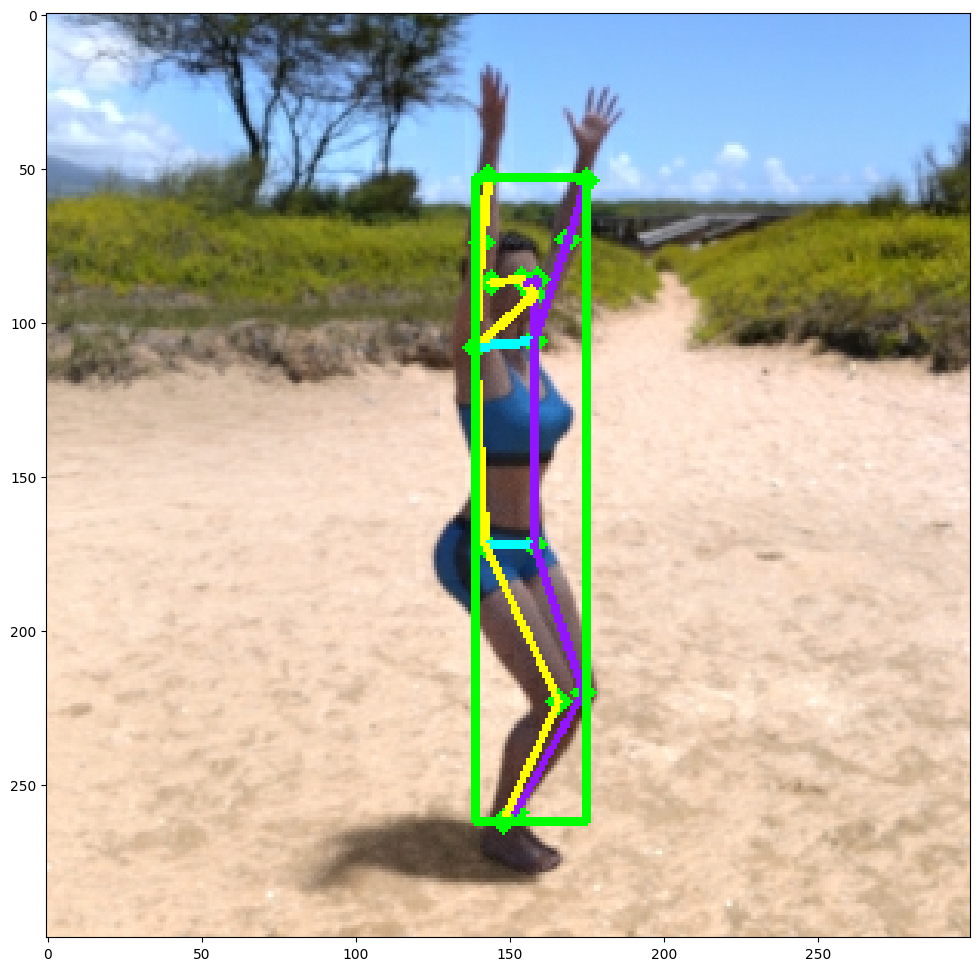

<ipython-input-25-94bcb442b927>:115: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coord = pose_landmarks.flatten().astype(np.str).tolist()
  0%|          | 1/400 [00:03<25:04,  3.77s/it]

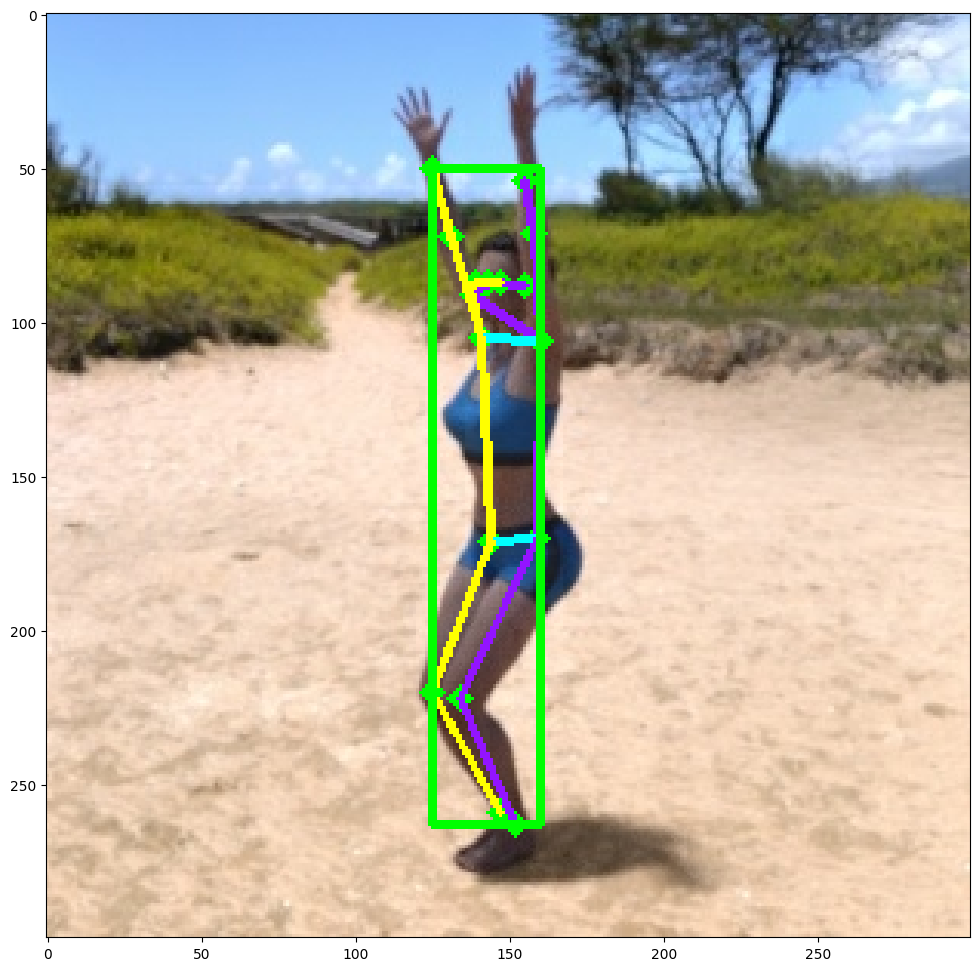

  0%|          | 2/400 [00:07<24:57,  3.76s/it]

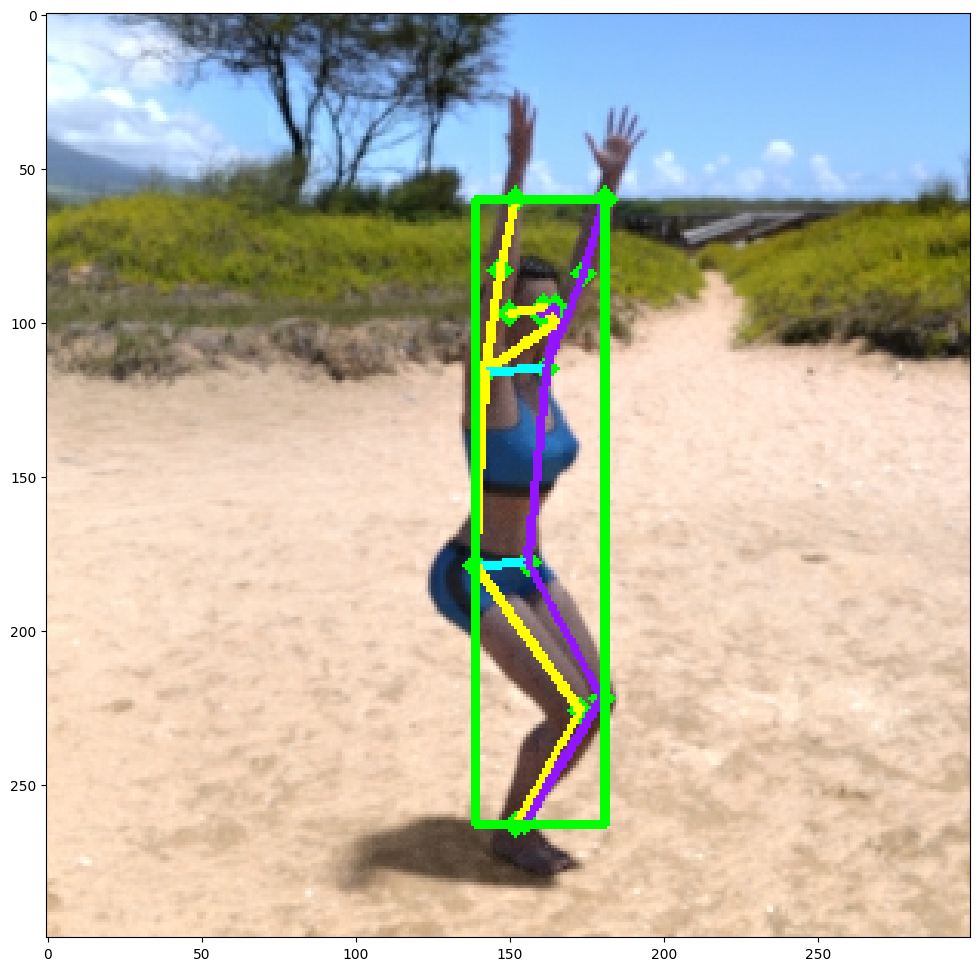

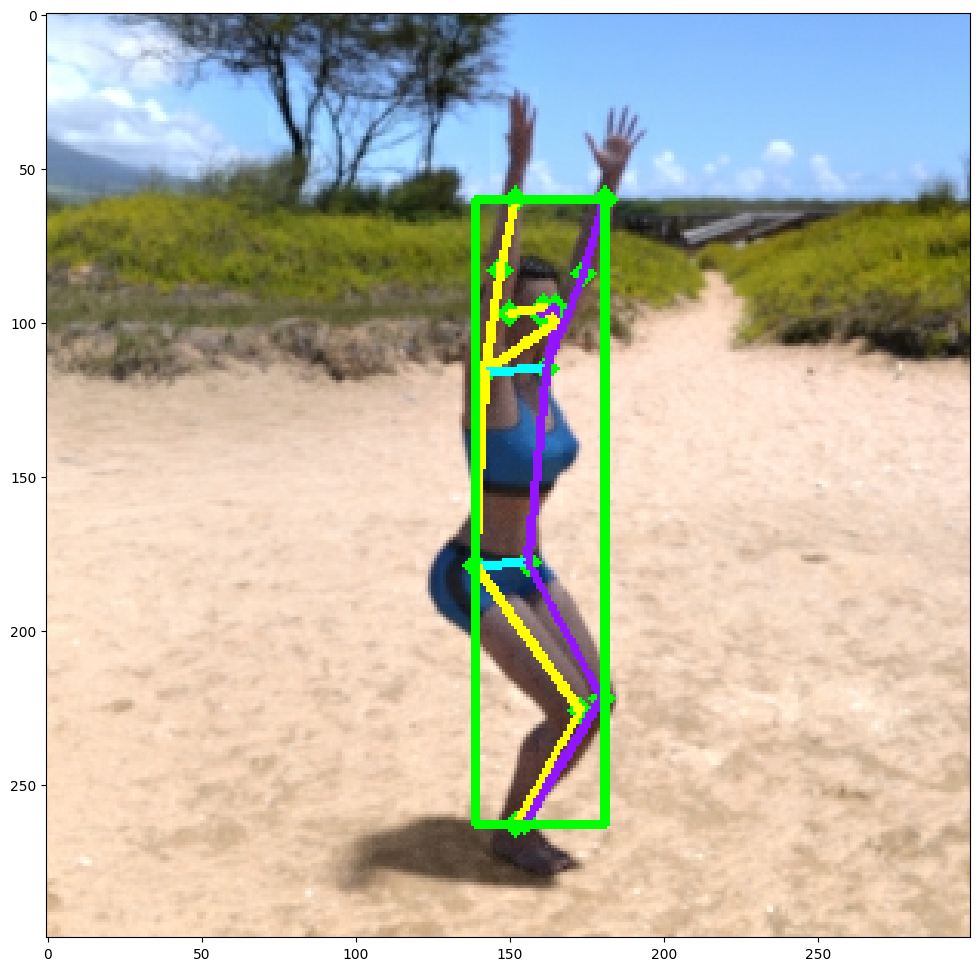

  1%|          | 3/400 [00:11<25:15,  3.82s/it]

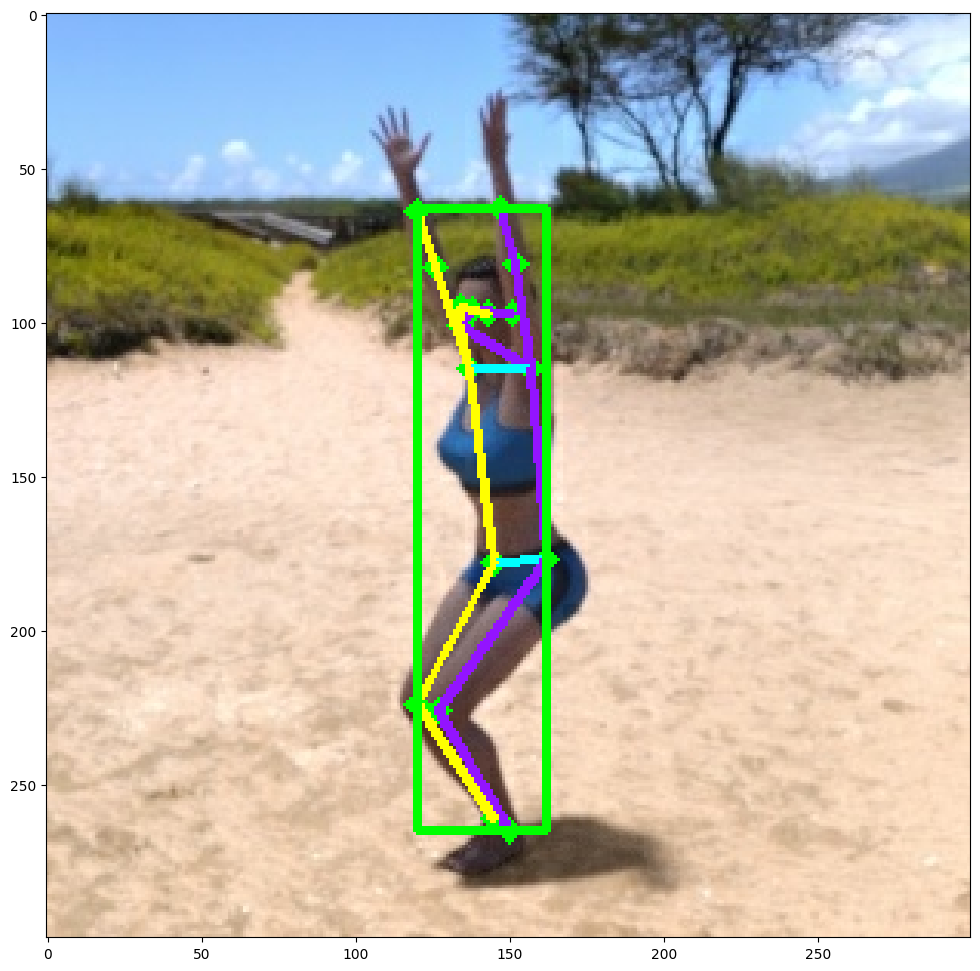

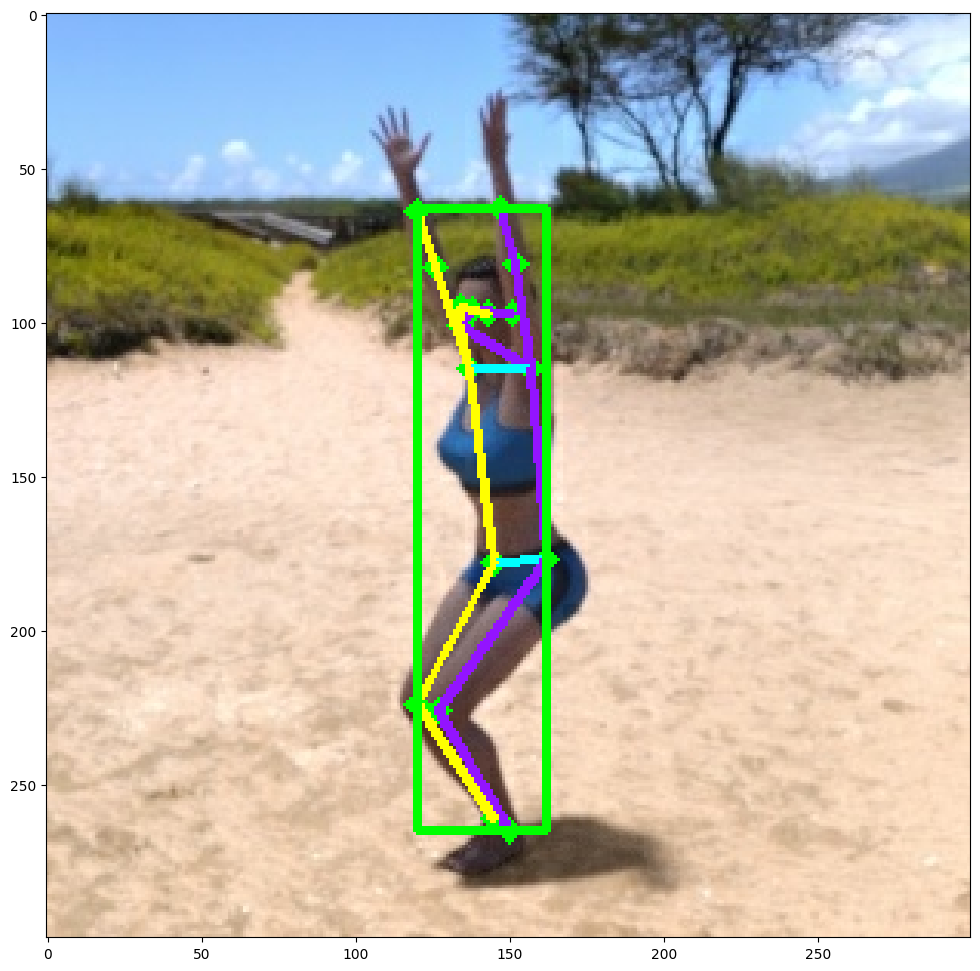

  1%|          | 4/400 [00:15<26:12,  3.97s/it]

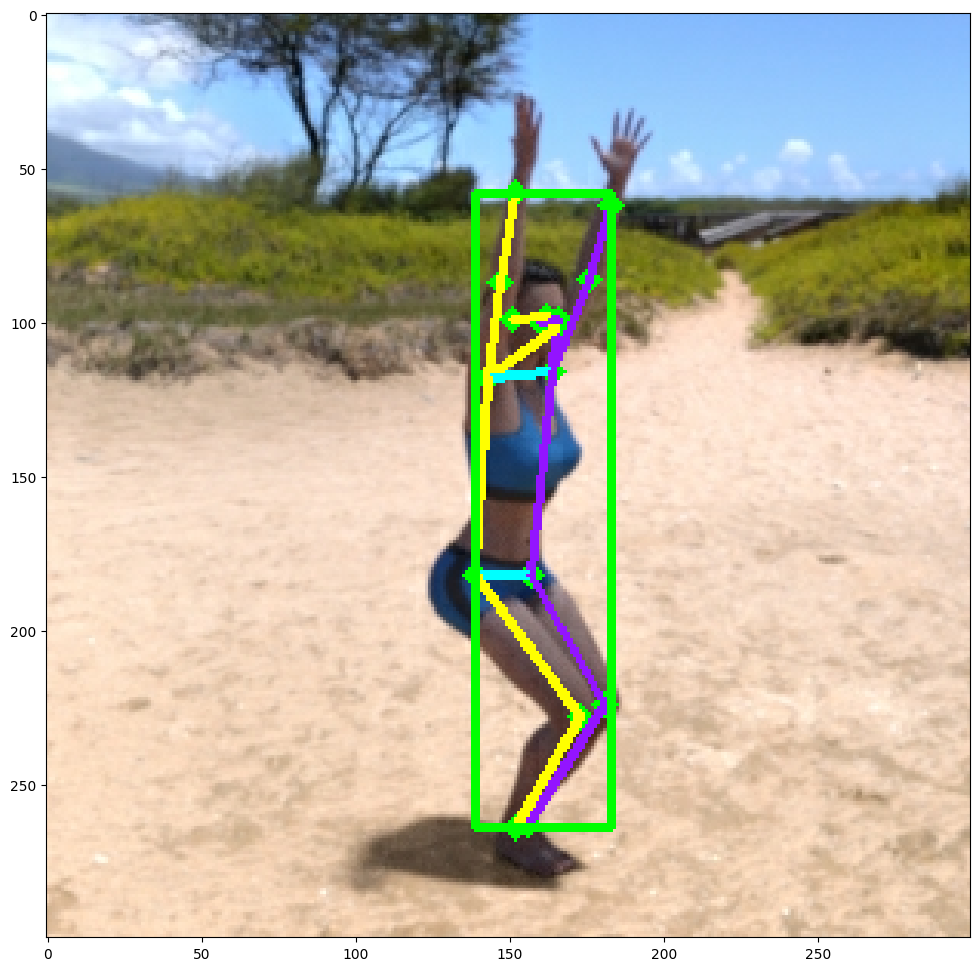

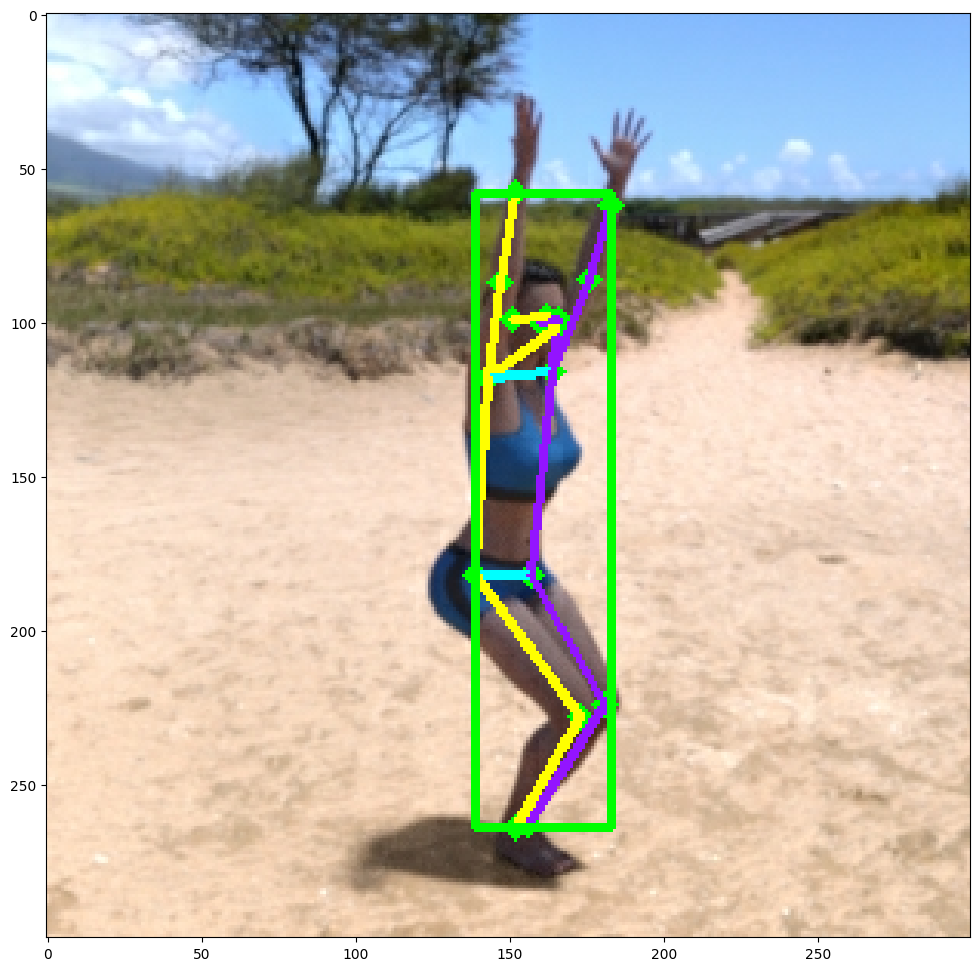

  1%|▏         | 5/400 [00:18<23:35,  3.58s/it]

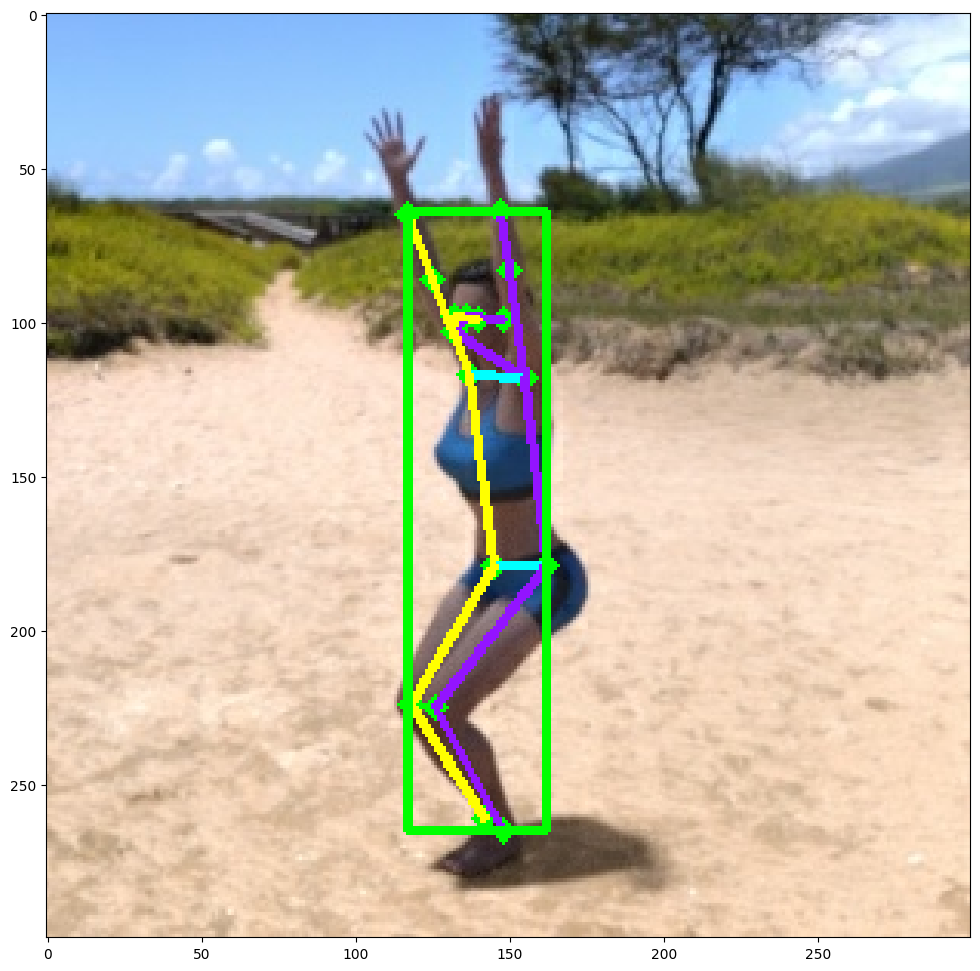

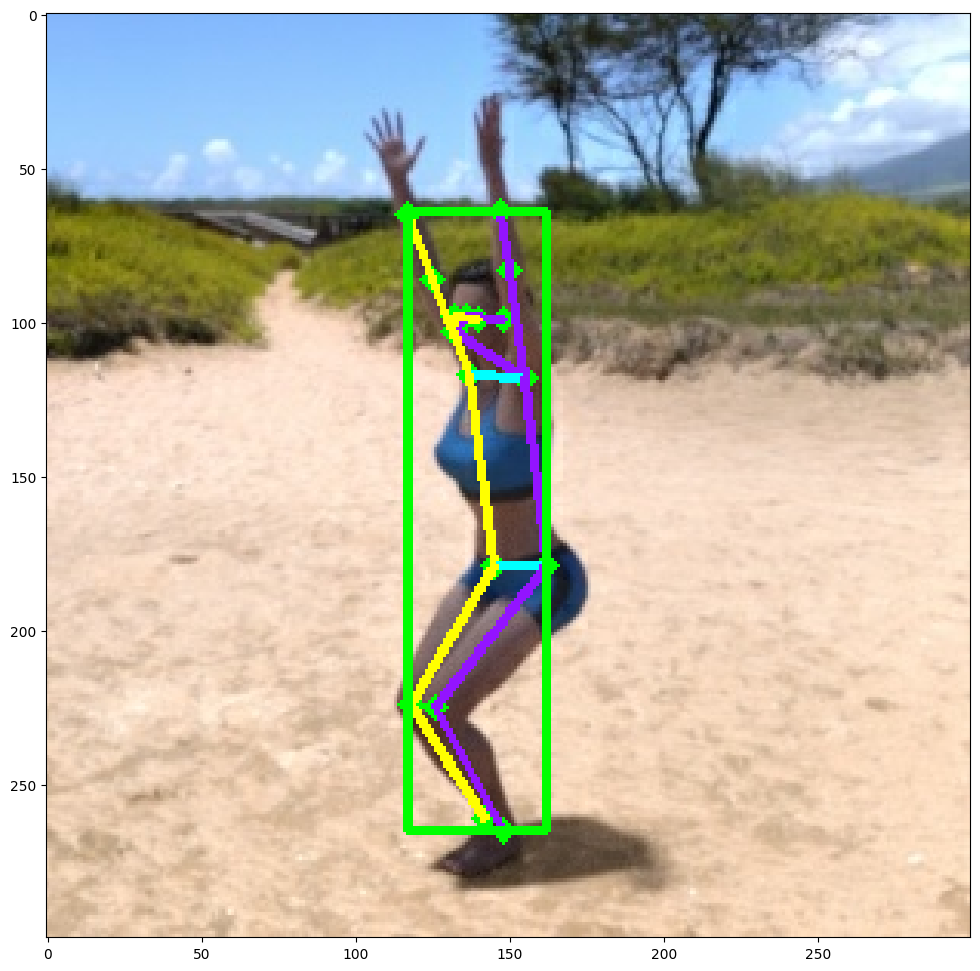

  2%|▏         | 6/400 [00:22<24:00,  3.66s/it]

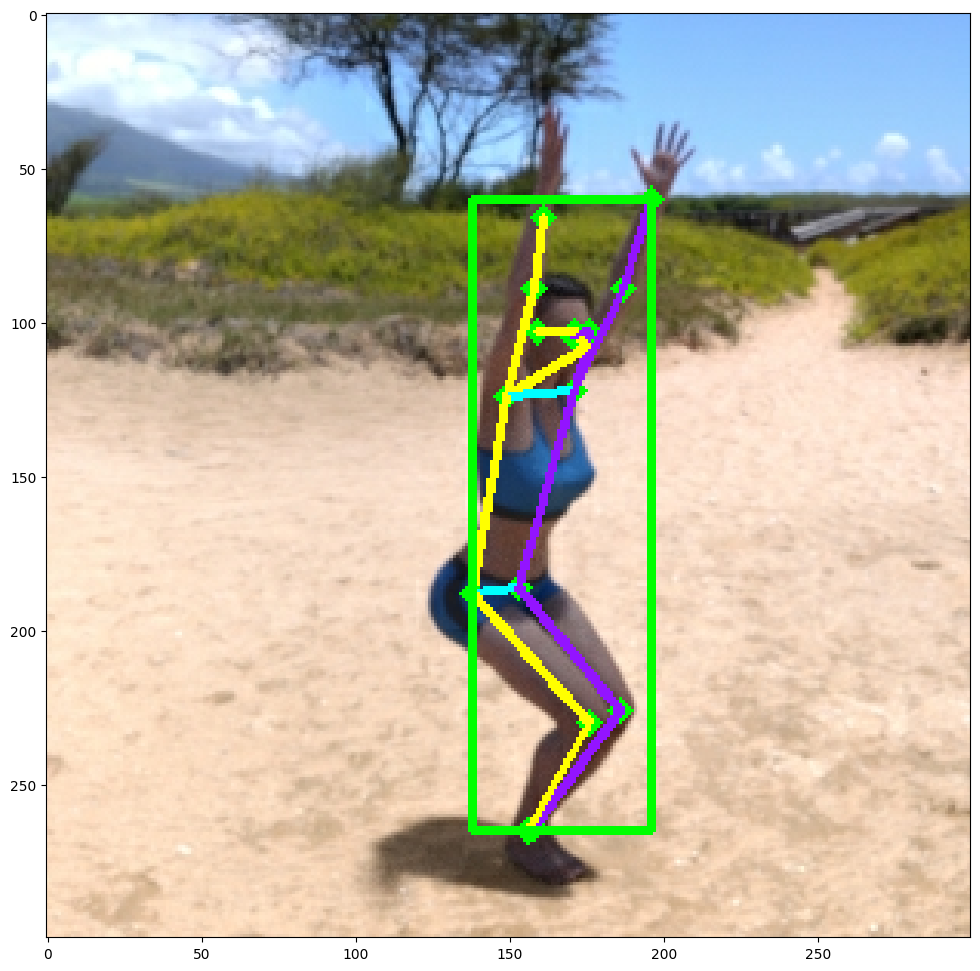

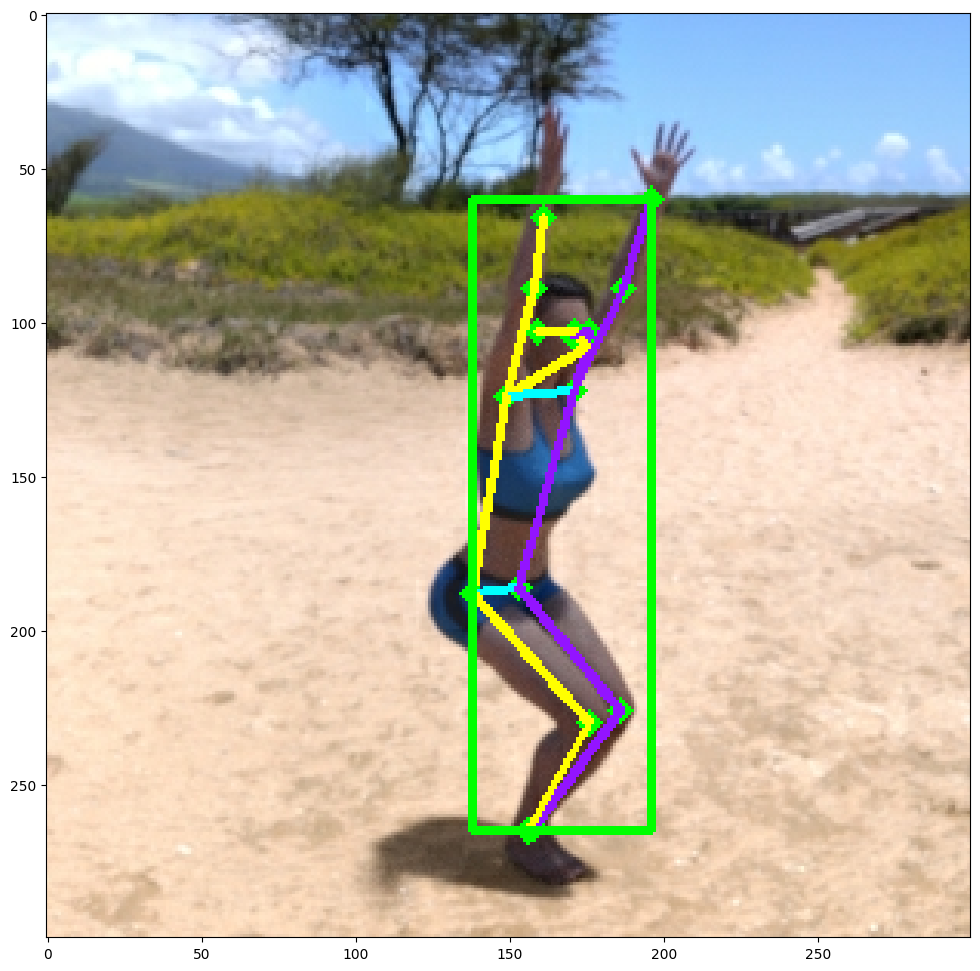

  2%|▏         | 7/400 [00:26<24:39,  3.76s/it]

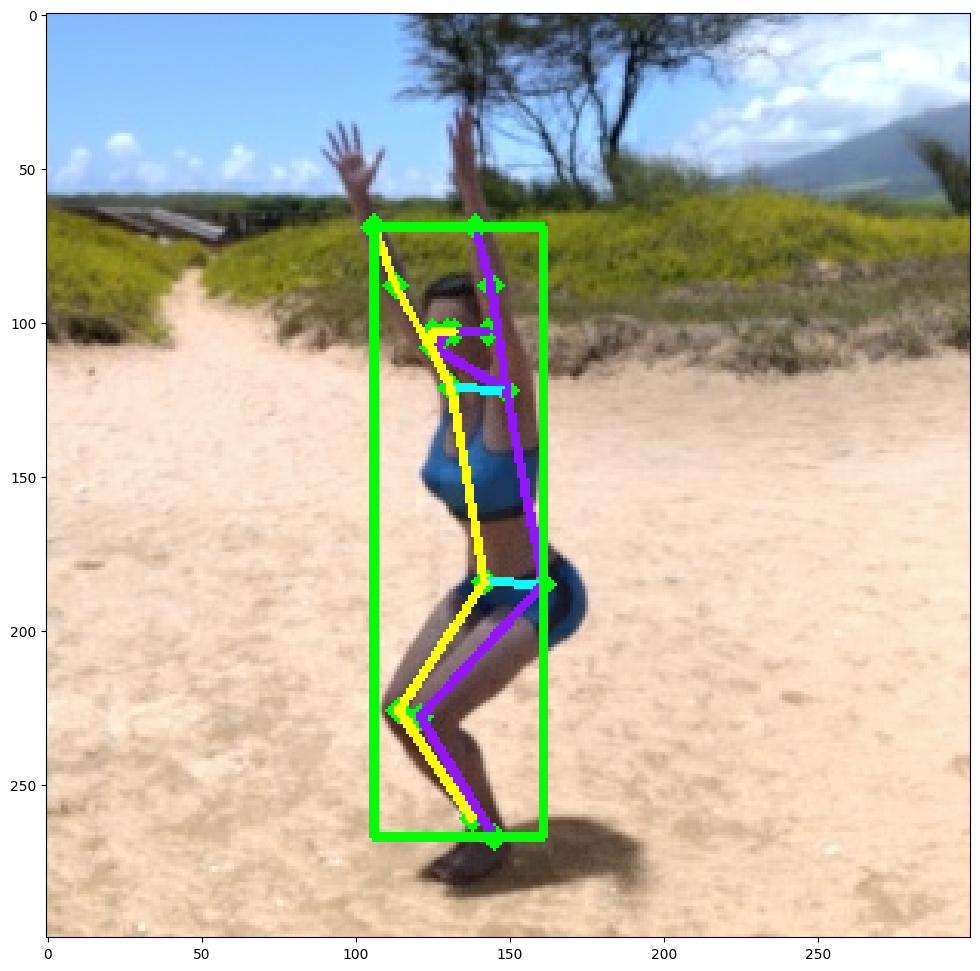

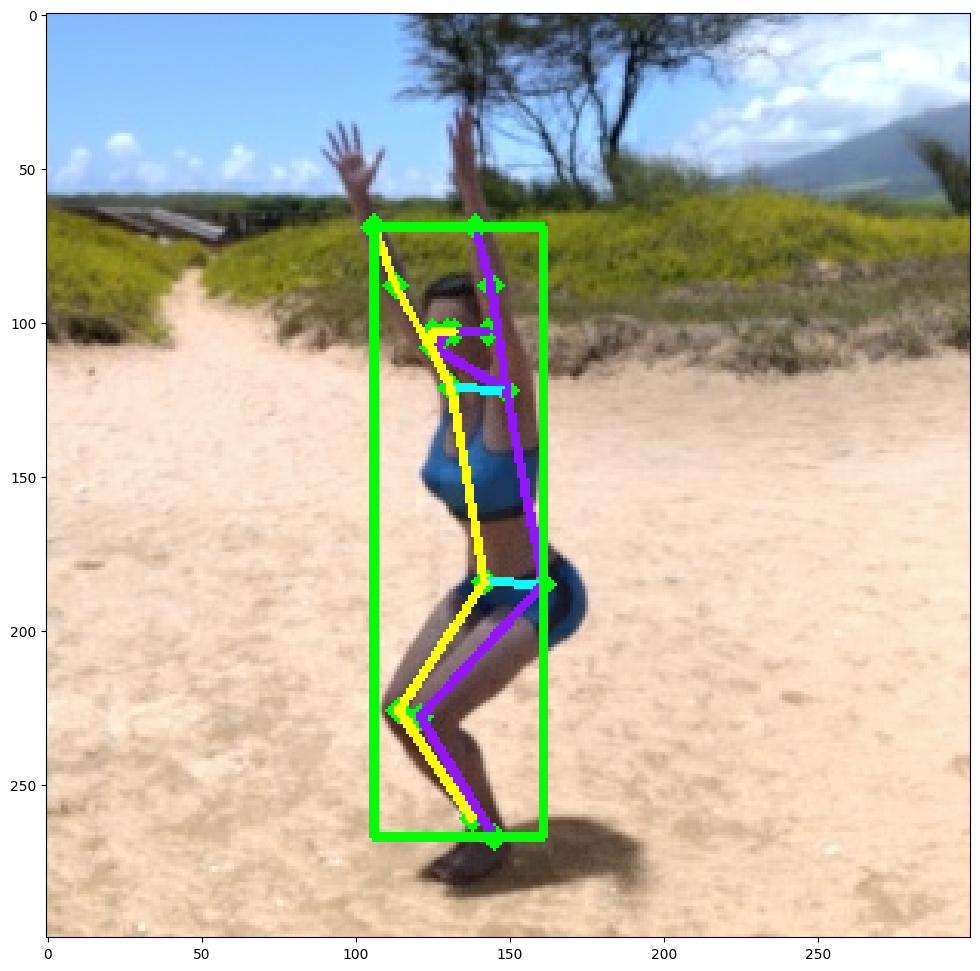

  2%|▏         | 8/400 [00:30<24:58,  3.82s/it]

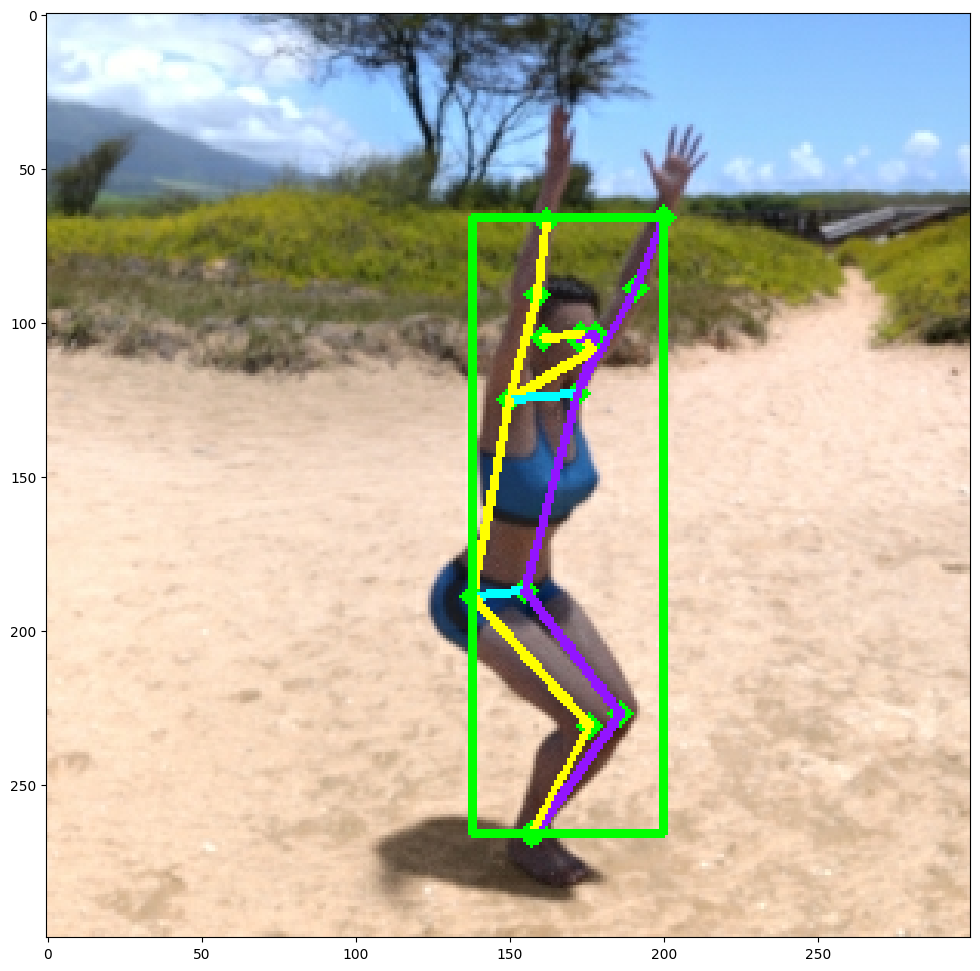

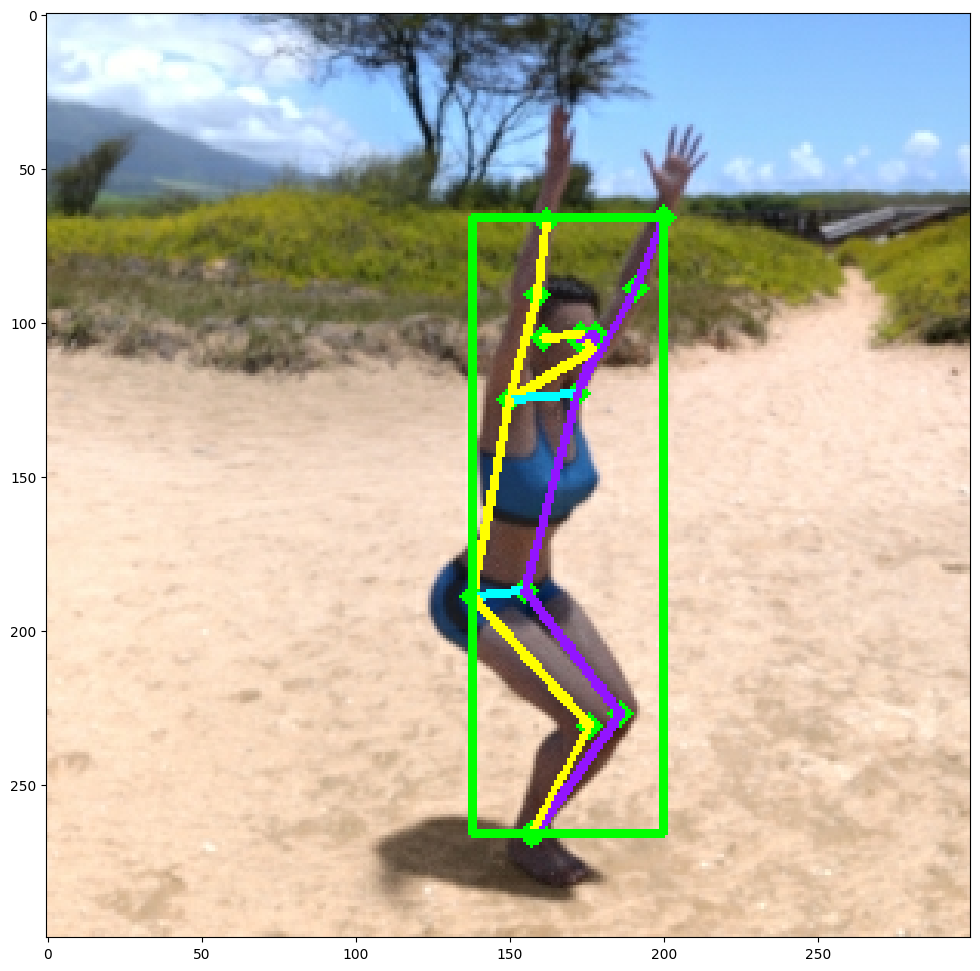

  2%|▏         | 9/400 [00:34<25:03,  3.85s/it]

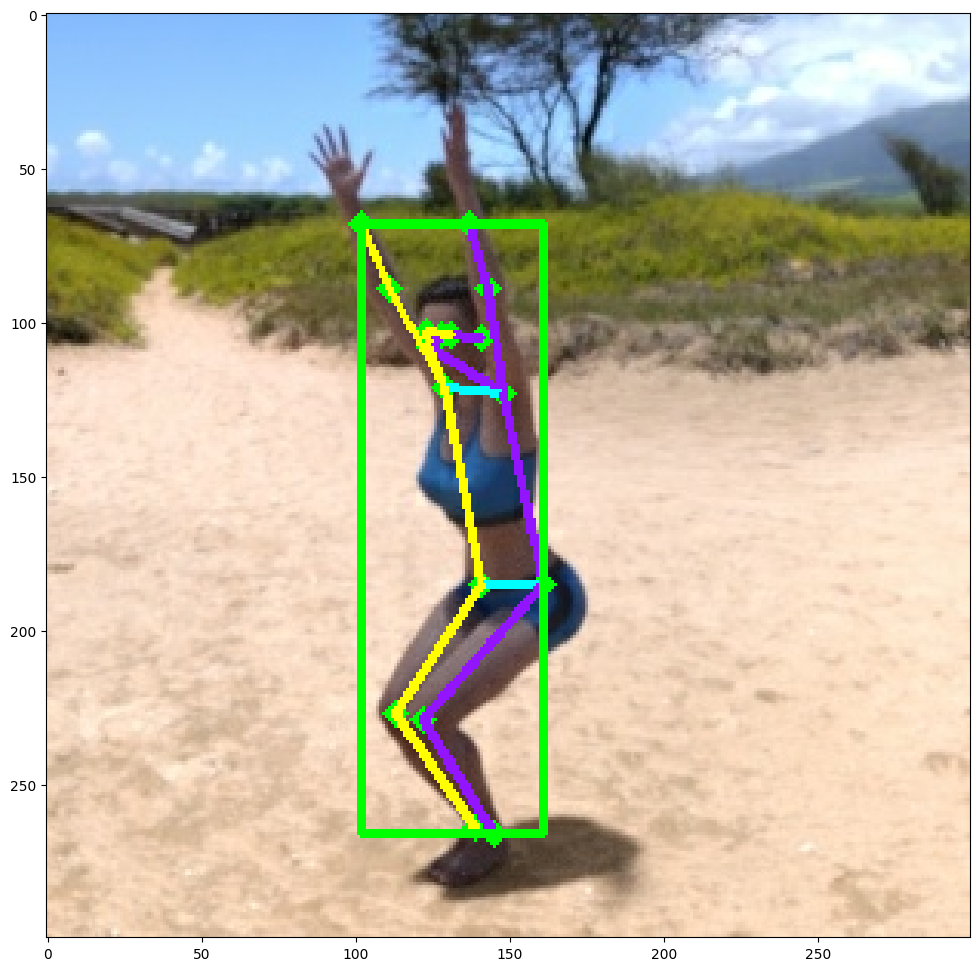

  2%|▎         | 10/400 [00:37<24:40,  3.80s/it]

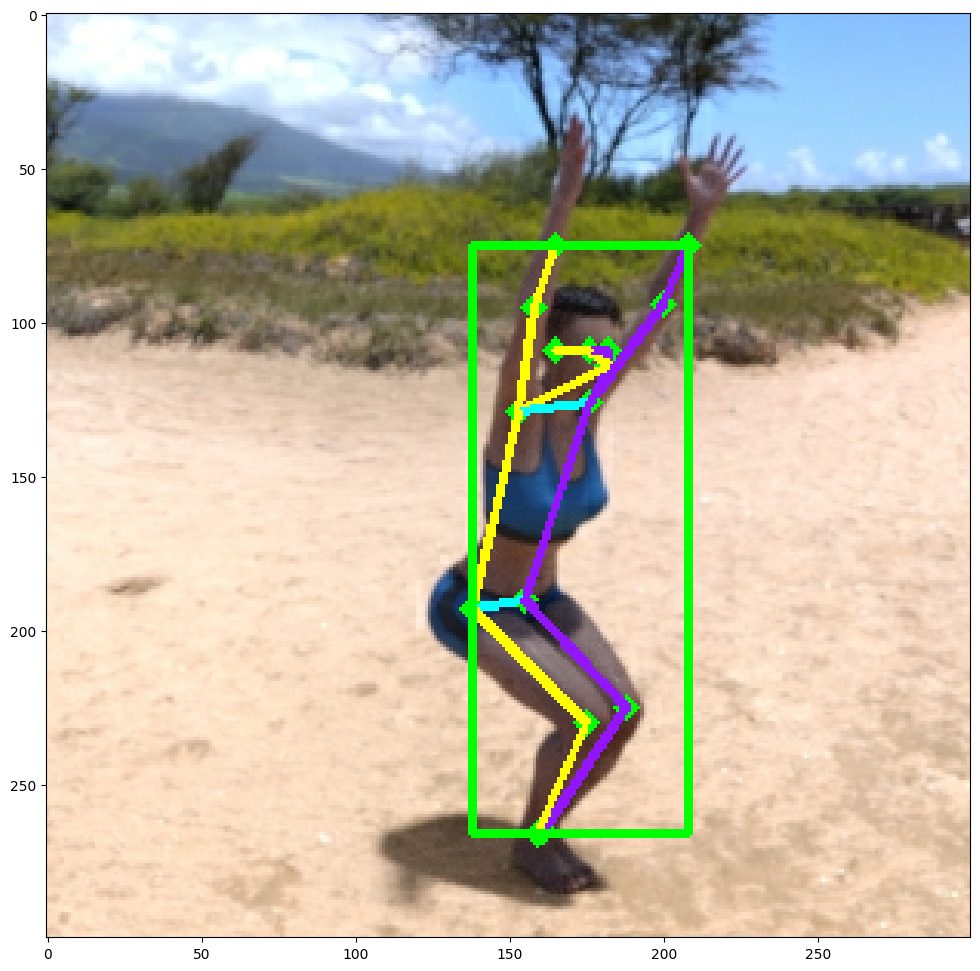

  3%|▎         | 11/400 [00:41<25:16,  3.90s/it]

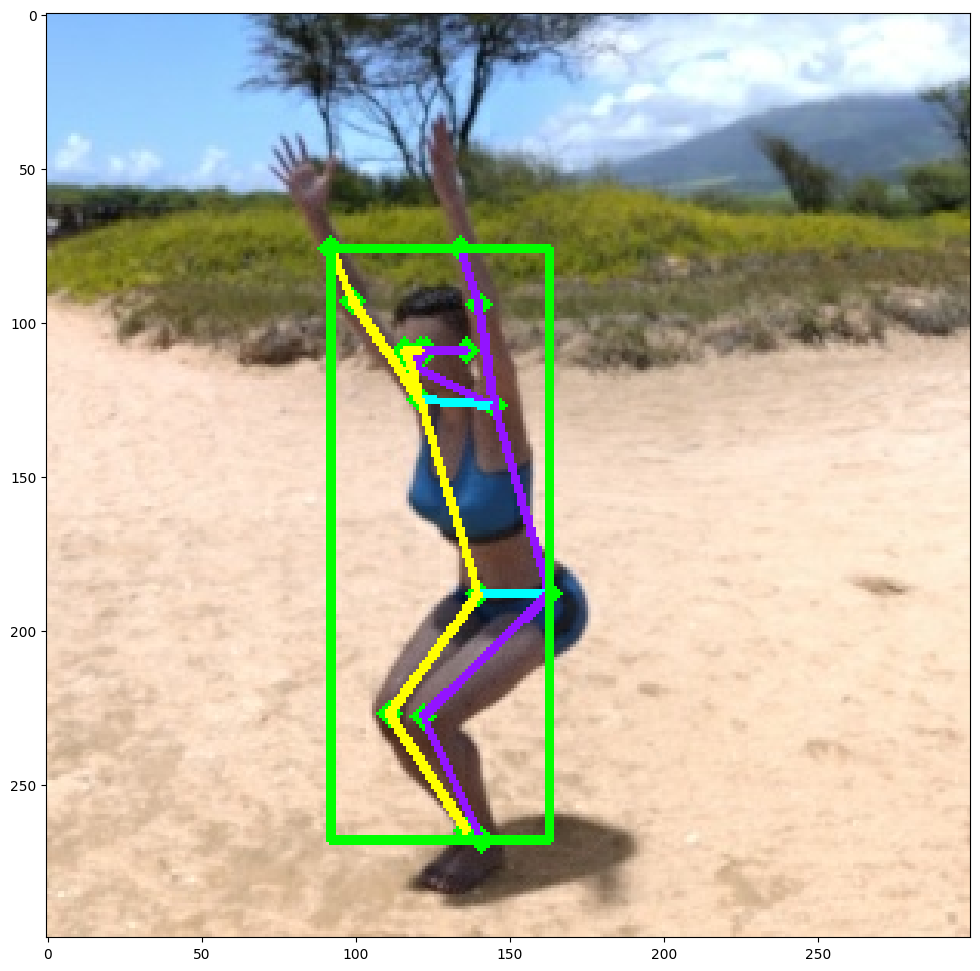

  3%|▎         | 12/400 [00:45<24:44,  3.83s/it]

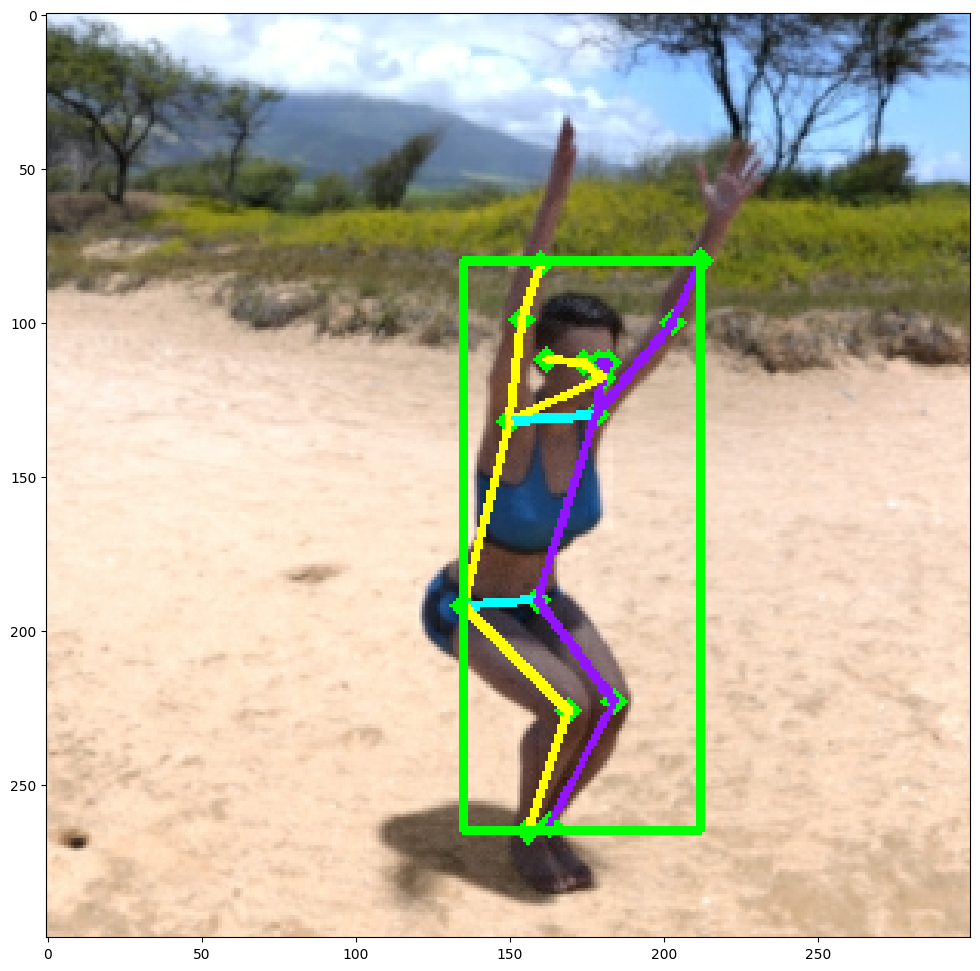

  3%|▎         | 13/400 [00:49<24:12,  3.75s/it]

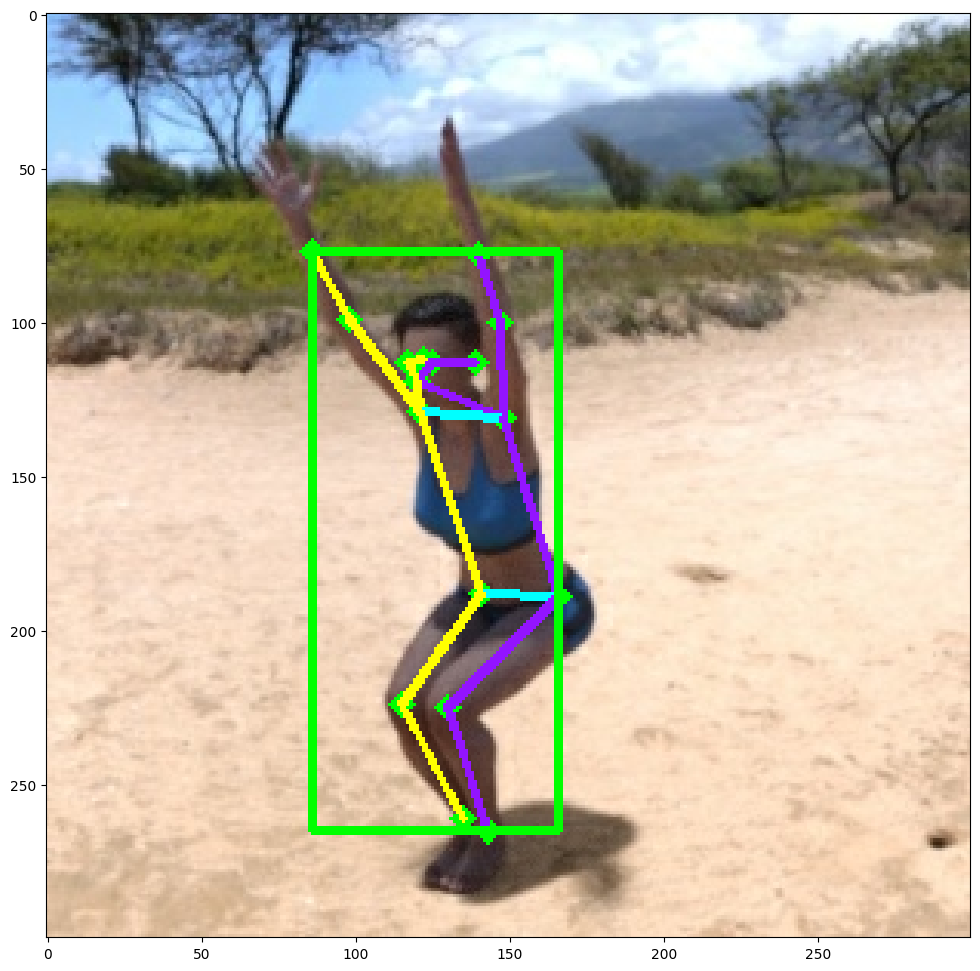

  4%|▎         | 14/400 [00:52<23:50,  3.71s/it]

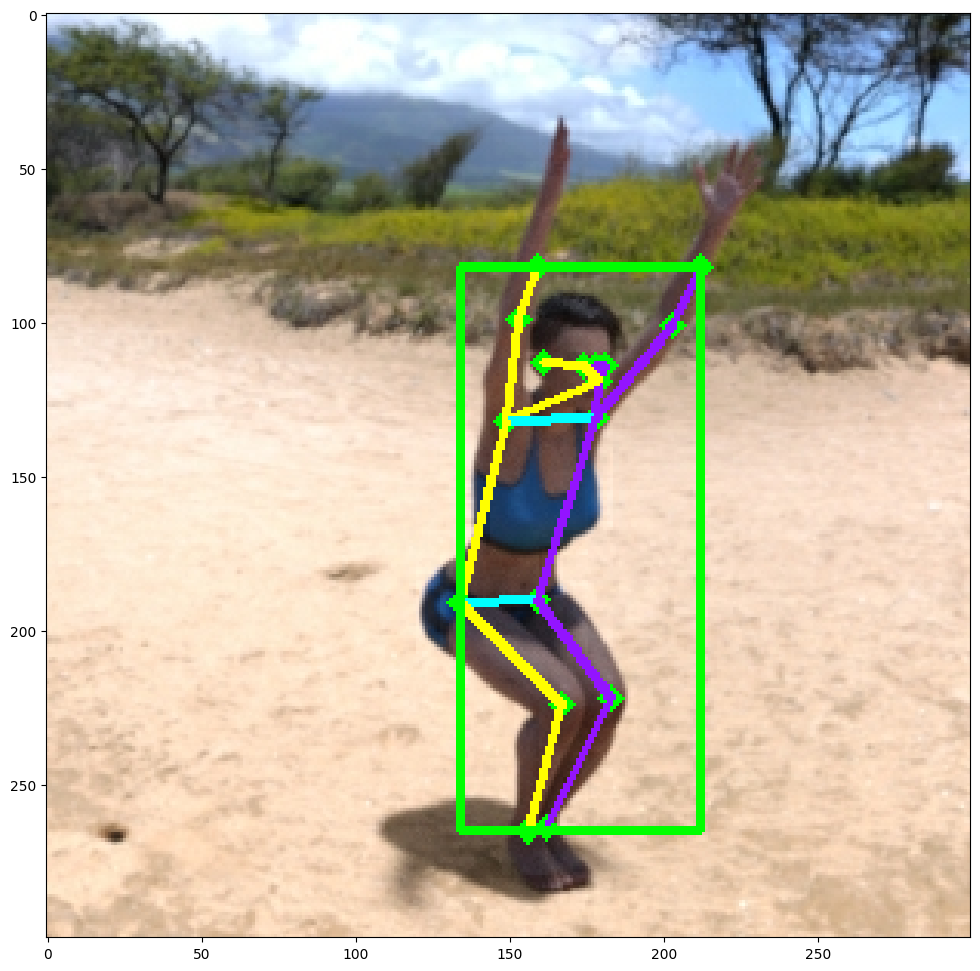

  4%|▍         | 15/400 [00:56<23:23,  3.65s/it]

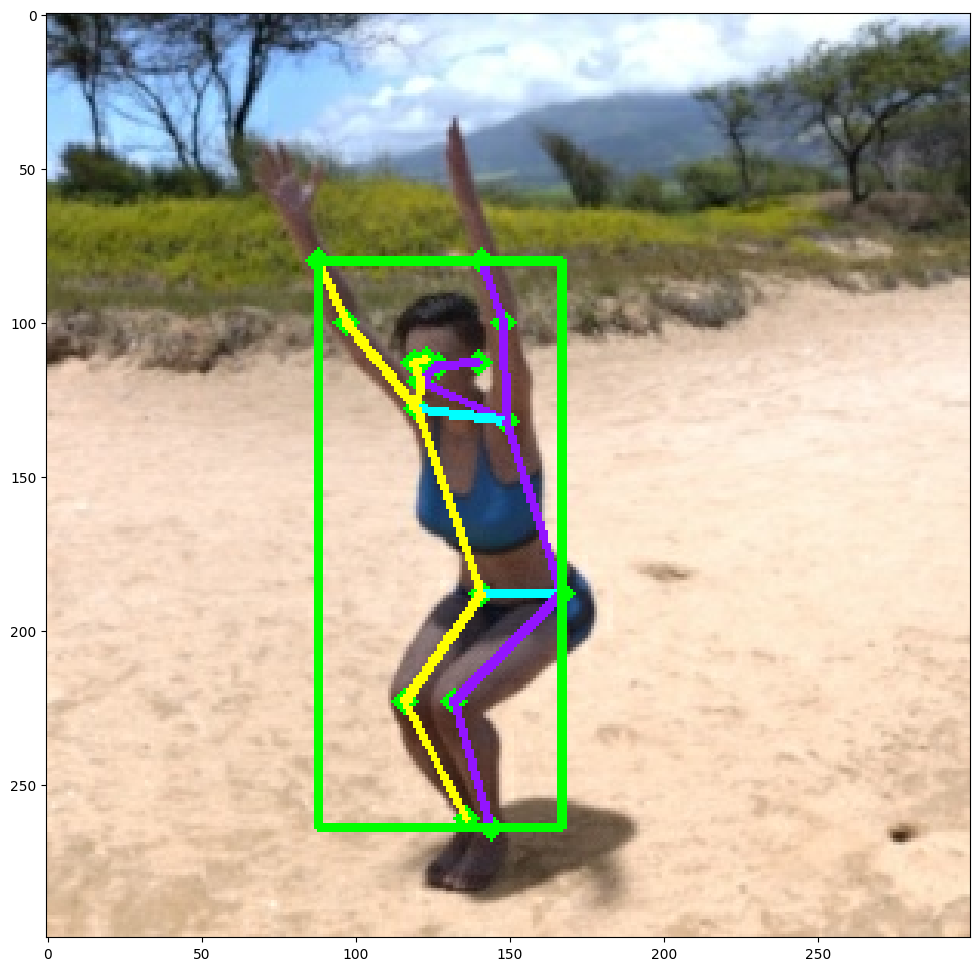

  4%|▍         | 16/400 [01:00<23:35,  3.69s/it]

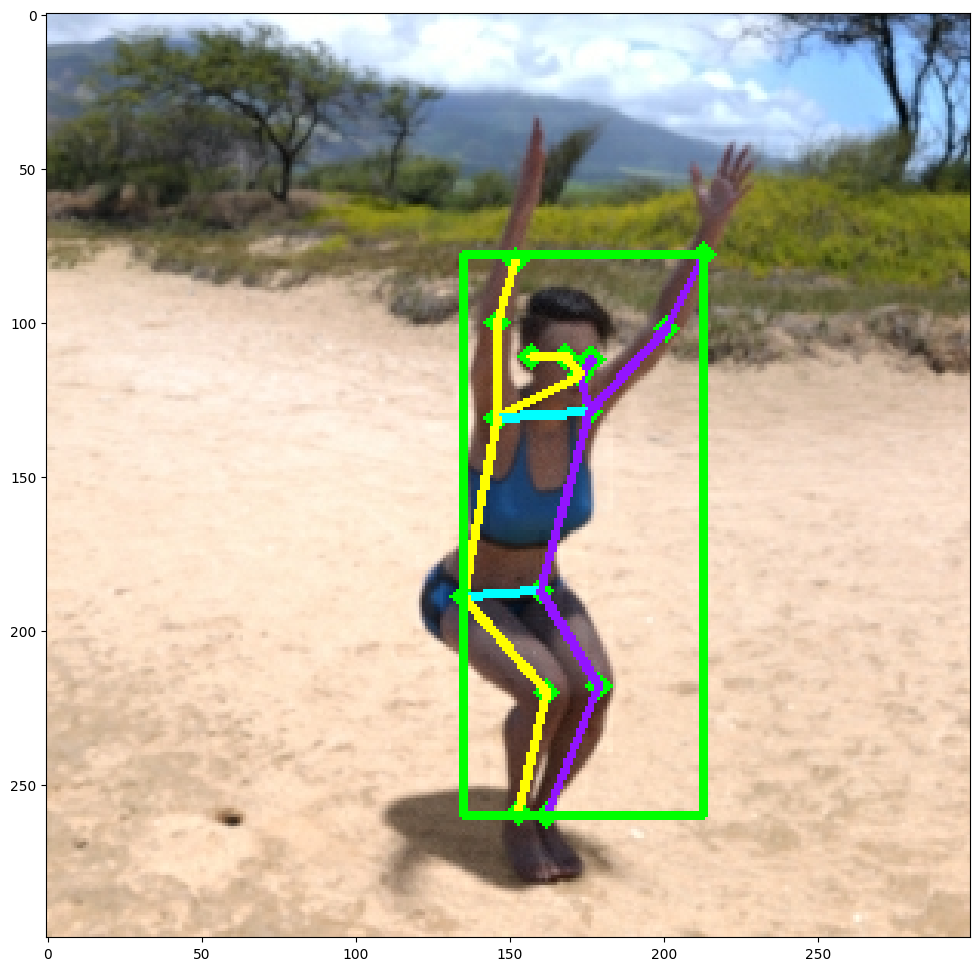

  4%|▍         | 17/400 [01:03<23:28,  3.68s/it]

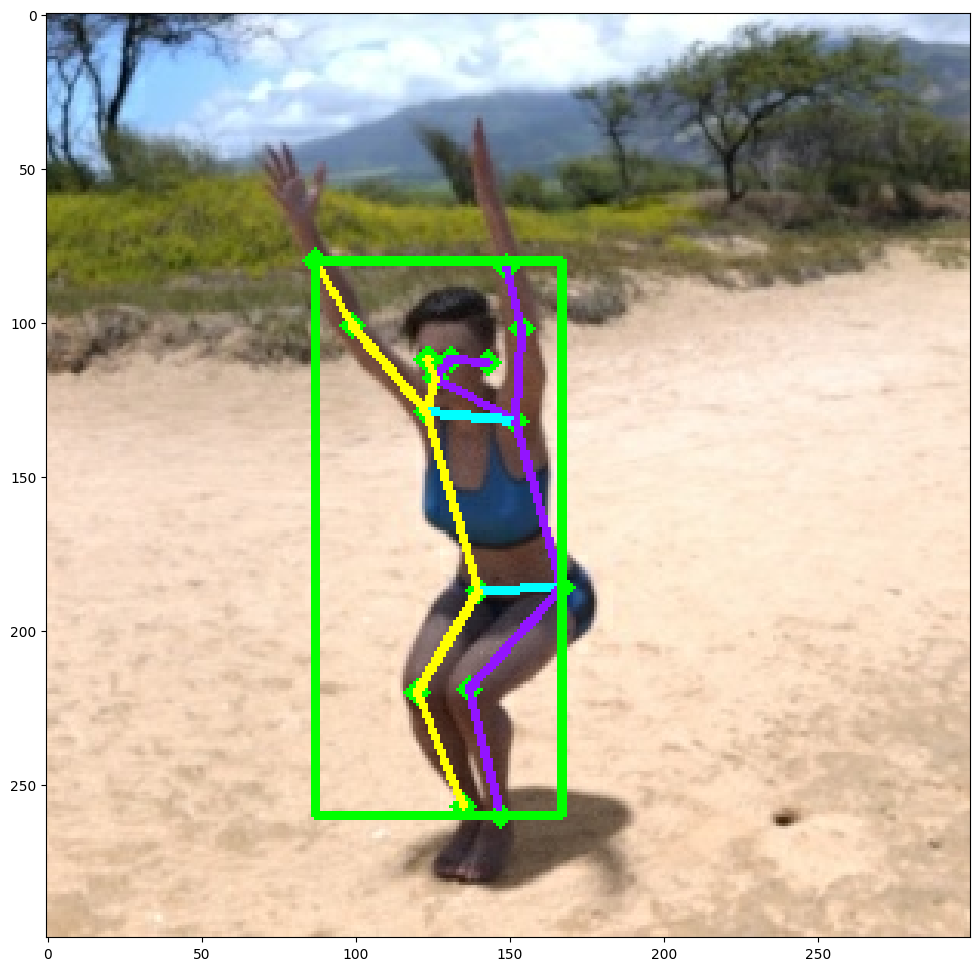

  4%|▍         | 18/400 [01:08<24:48,  3.90s/it]

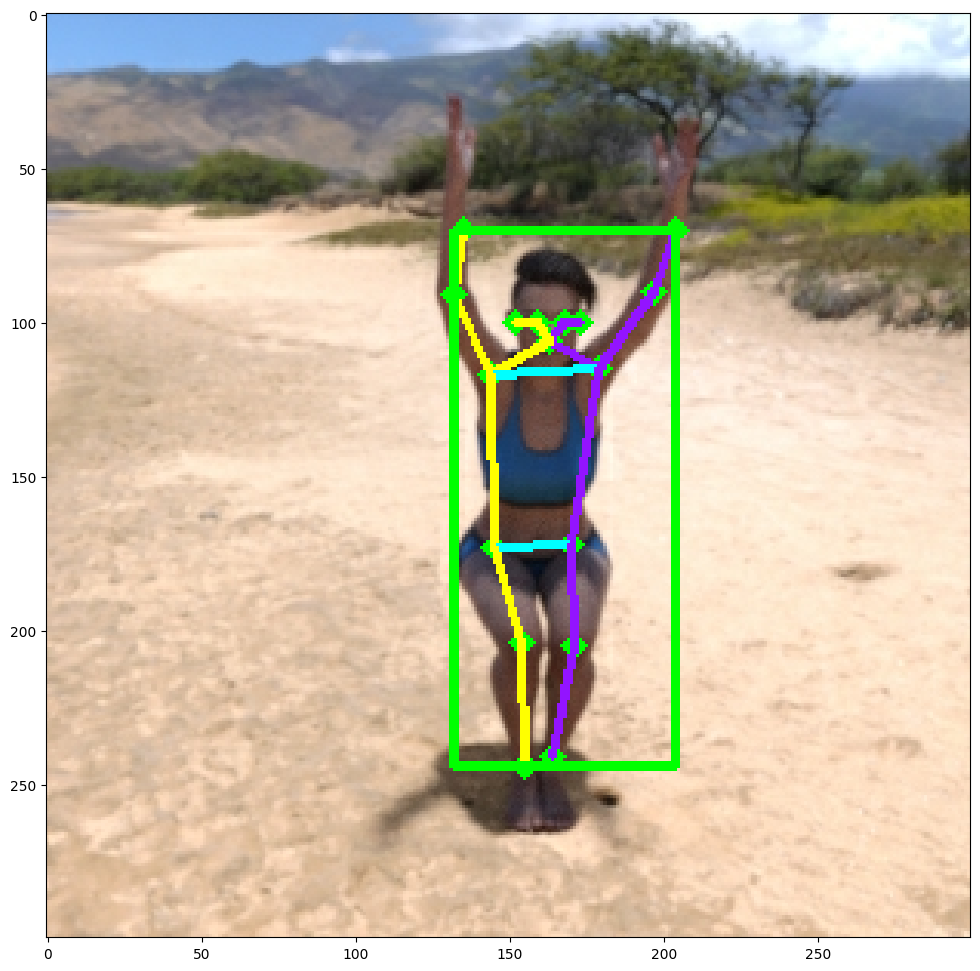

  5%|▍         | 19/400 [01:11<24:15,  3.82s/it]

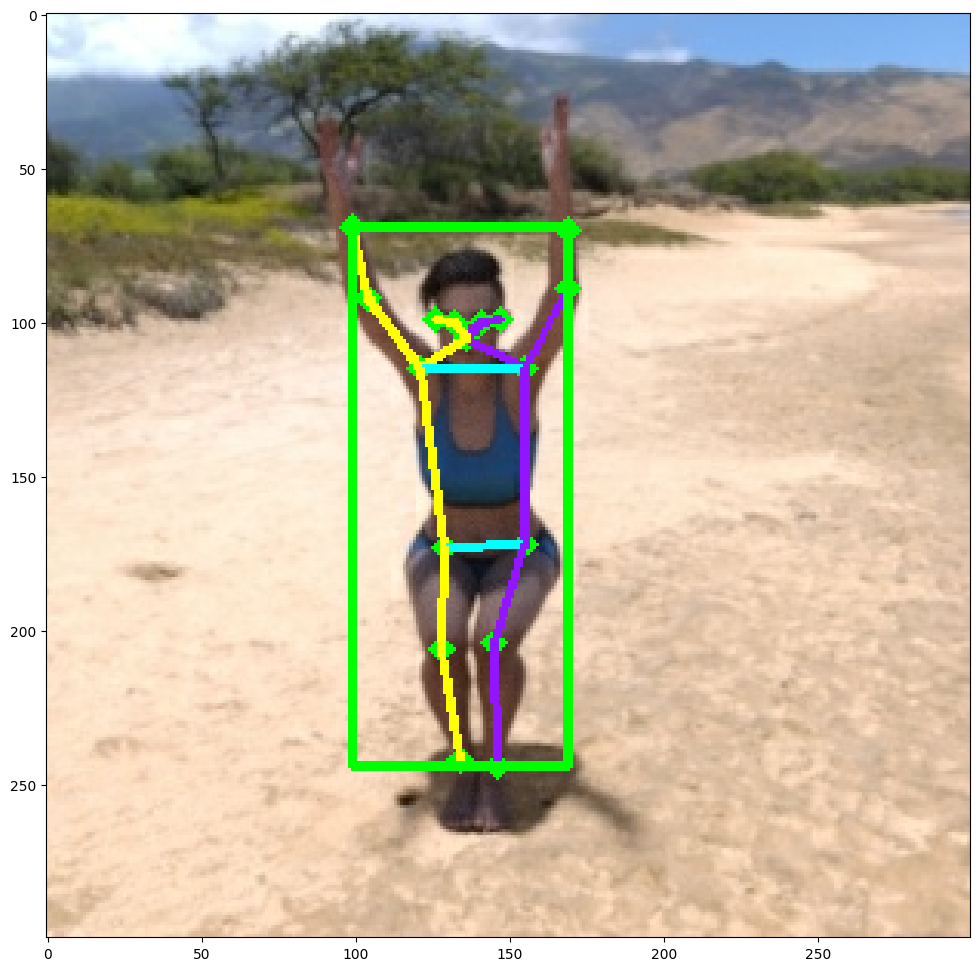

  5%|▌         | 20/400 [01:15<23:42,  3.74s/it]

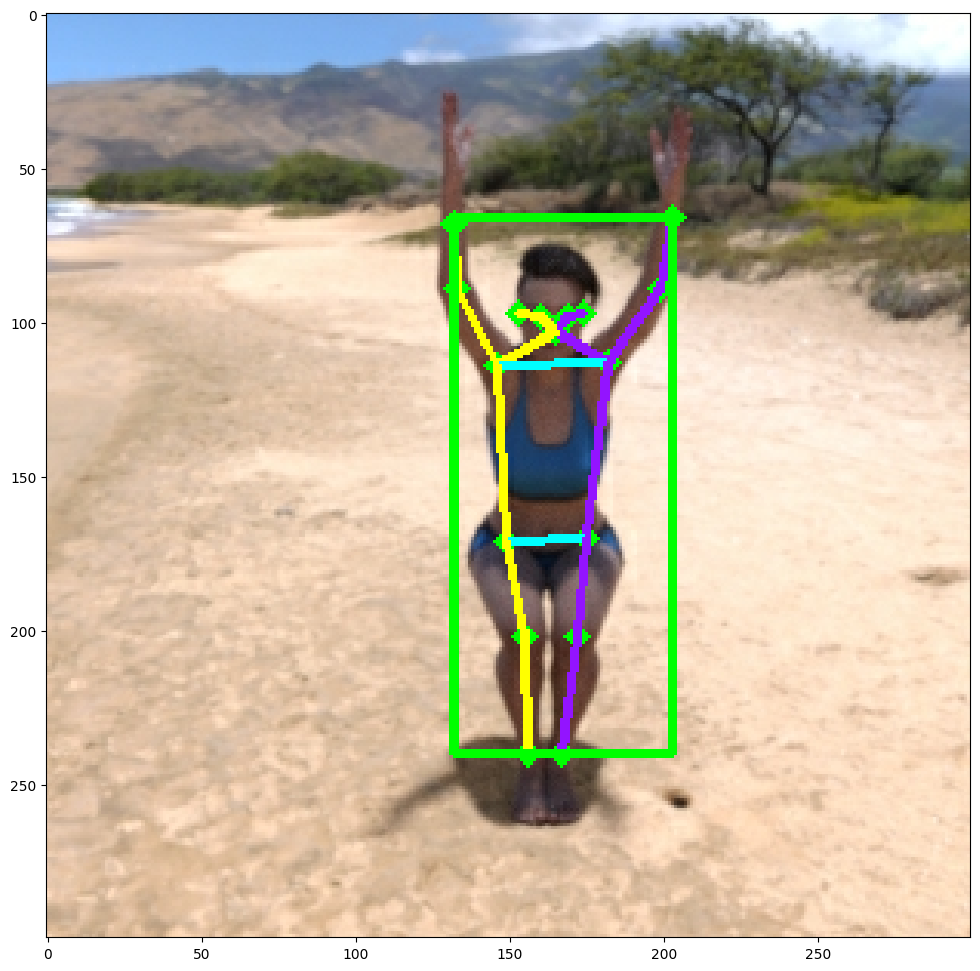

  5%|▌         | 21/400 [01:19<24:42,  3.91s/it]

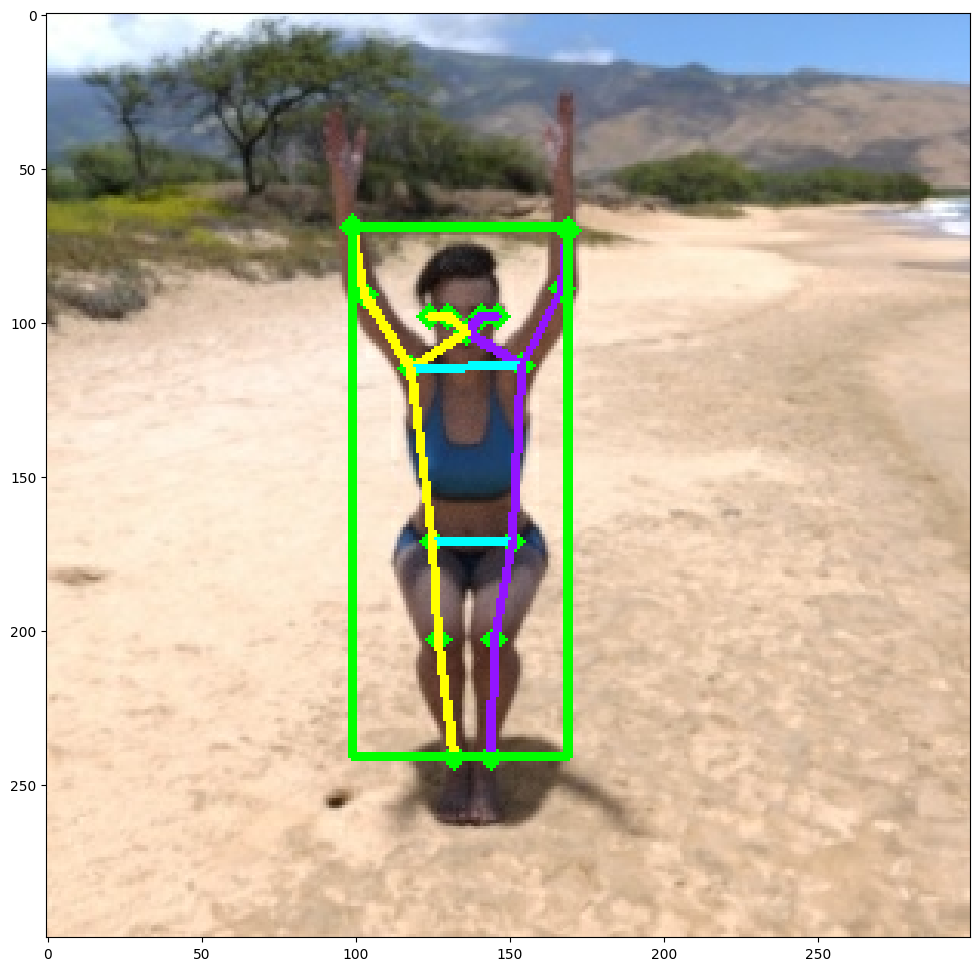

  6%|▌         | 22/400 [01:23<25:08,  3.99s/it]

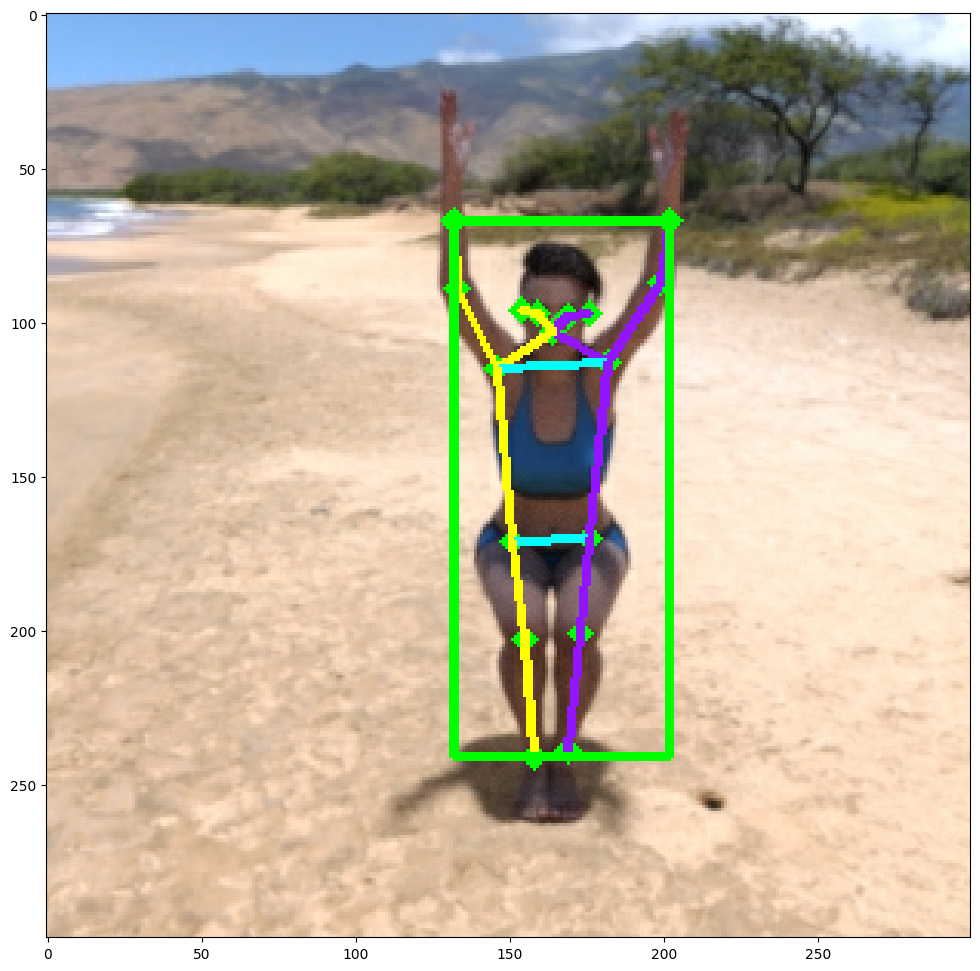

  6%|▌         | 23/400 [01:28<24:11,  3.85s/it]


KeyboardInterrupt: ignored

In [ ]:
#preprocessing module
import utils

yoga_poses_path = "/content/drive/MyDrive/DIP_project/projecttttt/yoga_poses" 
if(yoga_poses_path):
  print("true")
if('movenet_thunder.tflite' not in os.listdir()):
  print("true")
  wget.download('https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite', 'movenet_thunder.tflite')

movenet = Movenet('movenet_thunder')

def detect(input_tensor, inference_count=3):
    image_height, image_width, channel = input_tensor.shape
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    
    for _ in range(inference_count - 1):
        detection = movenet.detect(input_tensor.numpy(), 
                                reset_crop_region=False)
    
    return detection

class Preprocessor(object):
#     this class preprocess pose samples, it predicts keypoints on the images 
#     and save those keypoints in a csv file for the later use in the classification task 

        def __init__(self, images_in_folder,
                    csvs_out_path):
            self._images_in_folder = images_in_folder
            print(len(images_in_folder))
            # self._images_out_folder = images_out_folder
            self._csvs_out_path = csvs_out_path
            self._csvs_out_folder_per_class = 'csv_per_pose'
            self._message = []
            
            if(self._csvs_out_folder_per_class not in os.listdir()):
                os.makedirs(self._csvs_out_folder_per_class)
            
#             get list of pose classes
            self._pose_class_names = sorted(
                [n for n in os.listdir(images_in_folder)]
            )
    

        
        def process(self, detection_threshold=0.1):
#             Preprocess the images in the given folder
            for pose_class_name in self._pose_class_names:
#                 paths for pose class
                images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
                # images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
                csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                               pose_class_name + '.csv'
                                           )
                # create images_out_folder if it does not exist
                # if not os.path.exists(images_out_folder):
                #   os.makedirs(images_out_folder)

#               Detect landmarks in each images and write it to the csv files
                with open(csv_out_path, 'w') as csv_out_file:
                    csv_out_writer = csv.writer(csv_out_file,
                                                delimiter=',',
                                                quoting=csv.QUOTE_MINIMAL
                                               )
    #             get the list of images
                    image_names = sorted(
                        [n for n in os.listdir(images_in_folder)]
                    )
                    valid_image_count = 0
                    # Detect pose landmarks in each image
                    for image_name in tqdm.tqdm(image_names):
                        image_path = os.path.join(images_in_folder, image_name)
                        
                        try:
                            image = tf.io.read_file(image_path)
                            image = tf.io.decode_jpeg(image)
                        except:
                            self._message.append('Skipped' + image_path + ' Invalid image')
                            continue
                        
                        # skip images that is not RGB
                        if image.shape[2] != 3:
                            self.message.append('Skipped' + image_path + ' Image is not in RGB')
                            continue
                        
                        person = detect(image)
                        _ = draw_prediction_on_image(image.numpy(), person, 0, crop_region=None, 
                               close_figure=False, keep_input_size=True)
                        
                        
                        # Save landmarks if all landmarks above than the threshold
                        min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
                        should_keep_image = min_landmark_score >= detection_threshold
                        if not should_keep_image:
                            self._message.append('Skipped' + image_path + 'Keypoints score are below than threshold')
                            continue
                            
                        valid_image_count += 1
                        
                        output_overlay = draw_prediction_on_image(
                        image.numpy().astype(np.uint8), person, valid_image_count,
                        close_figure=True, keep_input_size=True)
                    
                        # Write detection result into an image file
                        output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                        # cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                        # Get landmarks and scale it to the same size as the input image
                        pose_landmarks = np.array(
                              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                                for keypoint in person.keypoints],
                                  dtype=np.float32)
                        
                        # writing the landmark coordinates to its csv files
                        coord = pose_landmarks.flatten().astype(np.str).tolist()
                        csv_out_writer.writerow([image_name] + coord)
                        
            print(self._message)

            # combine all per-csv class CSVs into a sigle csv file
            all_landmarks_df = self.all_landmarks_as_dataframe()
            all_landmarks_df.to_csv(self._csvs_out_path, index=False)

        def class_names(self):
            return self.pose_class_names
        
        def all_landmarks_as_dataframe(self):
            # Merging all csv for each class into a single csv file
            total_df = None
            for class_index, class_name in enumerate(self._pose_class_names):
                csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                               class_name + '.csv'
                                           )
                per_class_df = pd.read_csv(csv_out_path, header=None)
                
                # Add the labels
                per_class_df['class_no'] = [class_index]*len(per_class_df)
                per_class_df['class_name'] = [class_name]*len(per_class_df)
                
                # Append the folder name to the filename first column
                per_class_df[per_class_df.columns[0]] = class_name + '/' +  per_class_df[per_class_df.columns[0]]
                
                if total_df is None:
                    total_df = per_class_df
                else:
                    total_df = pd.concat([total_df, per_class_df], axis=0)
            
            list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart]
            
            header_name = []
            for columns_name in list_name:
                header_name += columns_name
            header_name = ['filename'] + header_name
            header_map = { total_df.columns[i]: header_name[i]
                             for i in range(len(header_name))
                         }
            
            total_df.rename(header_map, axis=1, inplace=True)
            
            return total_df

train_data_csv_path = "/content/drive/MyDrive/DIP_project/projecttttt/train_data.csv"
test_data_csv_path = "/content/drive/MyDrive/DIP_project/projecttttt/test_data.csv"

# preprocess training data
images_in_folder = os.path.join(yoga_poses_path, 'train')
l_files=os.listdir(yoga_poses_path)
print(len(l_files))
csvs_out_path = train_data_csv_path

# if(csvs_out_path):
#   print(len(csvs_out_path))
# for i in images_in_folder:
#   print(i)
train_preprocessor = Preprocessor(
    images_in_folder,
    csvs_out_path
)
train_preprocessor.process()   

# preprocessing testing data
# images_in_folder = os.path.join(yoga_poses_path, 'test')
# csvs_out_path = test_data_csv_path
# test_preprocessor = Preprocessor(
#     images_in_folder,
#     csvs_out_path
# )
# test_preprocessor.process()

In [ ]:
!cp "/content/csv_per_pose" "/content/drive/MyDrive/DIP_project/"

In [ ]:
#training
!pip install tensorflowjs --quiet

In [ ]:
import csv
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
# from data import BodyPart 
import tensorflow as tf
import tensorflowjs as tfjs

# tfjs_model_dir = 'model'
tfjs_model_dir = "/content/drive/MyDrive/DIP_project/projecttttt/model"


# loading final csv file
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['filename'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')
    
    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes


def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

    It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
    return pose_size



def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)
    return embedding


def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)


X, y, class_names = load_csv("/content/drive/MyDrive/DIP_project/projecttttt/train_data.csv")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_test, y_test, _ = load_csv("/content/drive/MyDrive/DIP_project/projecttttt/test_data.csv")


processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

inputs = tf.keras.Input(shape=(34))
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "/content/drive/MyDrive/DIP_project/projecttttt/weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
print('--------------TRAINING----------------')
history = model.fit(processed_X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


--------------TRAINING----------------
Epoch 1/200
79/81 [============================>.] - ETA: 0s - loss: 1.6905 - accuracy: 0.4367
Epoch 1: val_accuracy improved from -inf to 0.48899, saving model to /content/drive/MyDrive/DIP_project/projecttttt/weights.best.hdf5
81/81 [==============================] - 1s 9ms/step - loss: 1.6864 - accuracy: 0.4361 - val_loss: 1.2249 - val_accuracy: 0.4890
Epoch 2/200
79/81 [============================>.] - ETA: 0s - loss: 1.1292 - accuracy: 0.5791
Epoch 2: val_accuracy improved from 0.48899 to 0.71366, saving model to /content/drive/MyDrive/DIP_project/projecttttt/weights.best.hdf5
81/81 [==============================] - 0s 2ms/step - loss: 1.1288 - accuracy: 0.5794 - val_loss: 0.9365 - val_accuracy: 0.7137
Epoch 3/200
78/81 [===========================>..] - ETA: 0s - loss: 0.9011 - accuracy: 0.6787
Epoch 3: val_accuracy improved from 0.71366 to 0.72687, saving model to /content/drive/MyDrive/DIP_project/projecttttt/weights.best.hdf5
81/81 [===

In [ ]:

print('-----------------EVAUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('LOSS: ', loss)
print("ACCURACY: ", accuracy)


tfjs.converters.save_keras_model(model, tfjs_model_dir)
print('tfjs model saved at ',tfjs_model_dir)

-----------------EVAUATION----------------
28/28 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 0.9989
LOSS:  0.005378399975597858
ACCURACY:  0.9988597631454468
tfjs model saved at  /content/drive/MyDrive/DIP_project/projecttttt/model


In [ ]:
# !pip freeze > "/content/drive/MyDrive/DIP_project/projecttttt/requirements.txt"

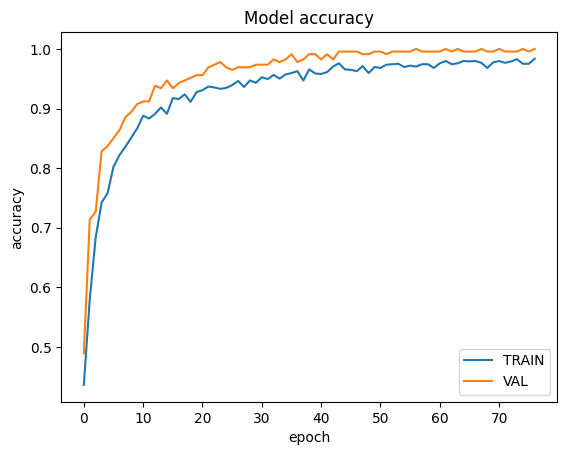

In [ ]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()


In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

ValueError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))
     

ValueError: ignored

In [ ]:
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
     